# ENTREGA ENSEMBLE LEARNING

## Integrantes:

 + Jorge Peralta Fernández-Revuelta Lechuga

 + Alberto García Martín

 + Ignacio Urretavizcaya Tato

 + Juan López Segura

In [1]:
# EDA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Clustering

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
import numpy as np
from scipy.cluster.vq import vq
from sklearn.mixture import GaussianMixture

#Bagging
from sklearn.inspection import permutation_importance

#Booosting
from sklearn.ensemble import   AdaBoostRegressor, GradientBoostingRegressor



# Other
from mltools import unsupervised_tools as UT
from sklearn.linear_model  import Ridge
from mltools import model_tools as MT
from sklearn.neural_network import MLPRegressor

# Predictions
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score



In [2]:
import warnings
warnings.filterwarnings('ignore')


## PASO 1: EDA

### 1. Lectura de Datos

In [2]:
nom_fi_datos_Irrad = "data/G10A_DATOS_IRRAD.csv"
df_orig_Irrad = pd.read_csv(nom_fi_datos_Irrad)

# parseamos la fecha (cadena) para que sea un datetime con formato yyyy/mm/dd

df_orig_Irrad['FECHA'] = pd.to_datetime(df_orig_Irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_Irrad.loc[:,'FECHA']
df_orig_Irrad['FECHA'] =  s.dt.date

In [3]:
nom_fi_datos_Util = "data/G10A_DATOS_UTIL.csv"
df_orig_Util = pd.read_csv(nom_fi_datos_Util)

df_orig_Util['FECHA'] = pd.to_datetime(df_orig_Util['FECHA'], format='%Y-%m-%d')

s = df_orig_Util.loc[:,'FECHA']
df_orig_Util['FECHA'] =  s.dt.date

El primero de los dos dataframes contiene datos de irradiación solar acumulada cada 3 horas (es decir, la irradaición solar del tramo de la hora 0 es la acumulada de las horas 0, 1 y 2, su suma). Se conoce como irradiación solar a la irradiación neta absorbida por la superficie terrestre, siendo ésta la suma de la radiación directa, difusa (a través de nubes) y reflejada (por ejemplo, reflejada del suelo).

Por otro lado tenemos los registros correspondientes de la utilización solar fotovoltaica, que se define como la generación solar horaria entre la potencia (por lo que es adimensional, y se encuentra entre 0 y 1). Además, la utilización horaria del tramo h no es la suma de las horas $h$, $h+1$ y $h+2$, sino su media.

In [4]:
# Unir los DataFrames en uno solo llamado df
df2 = pd.merge(df_orig_Irrad, df_orig_Util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'])

df2.head()

FECHA  IRRADH00  IRRADH03  IRRADH06   IRRADH09   IRRADH12   IRRADH15  \
0  2015-01-01       0.0       0.0       0.0  393513.78  1228750.1  598885.60   
1  2015-01-02       0.0       0.0       0.0  338985.30  1155297.4  476027.28   
2  2015-01-03       0.0       0.0       0.0  377949.56  1216140.1  551573.30   
3  2015-01-04       0.0       0.0       0.0  363471.10  1230439.8  604020.10   
4  2015-01-05       0.0       0.0       0.0  308257.75  1126382.5  544212.94   

   IRRADH18  IRRADH21  ANNO  ...  DIA  DIASEM  UTILH00  UTILH03   UTILH06  \
0       0.0       0.0  2015  ...    1       3      0.0      0.0  0.032237   
1       0.0       0.0  2015  ...    2       4      0.0      0.0  0.016250   
2       0.0       0.0  2015  ...    3       5      0.0      0.0  0.018172   
3       0.0       0.0  2015  ...    4       6      0.0      0.0  0.014853   
4       0.0       0.0  2015  ...    5       0      0.0      0.0  0.015036   

    UTILH09   UTILH12   UTILH15  UTILH18  UTILH21  
0  0.370669  0.468188  0.106079  0.00000      0.0  
1  0.282763  0.366319  0.071596  0.00000      0.0  
2  0.329772  0.429112  0.098794  0.00000      0.0  
3  0.265177  0.452586  0.107071  0.00000      0.0  
4  0.279424  0.354116  0.067873  0.00002      0.0  

[5 rows x 21 columns]

### 2. Valores Faltantes y Tipos de Variables

In [5]:
#Info and type of variables
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FECHA     2192 non-null   object 
 1   IRRADH00  2192 non-null   float64
 2   IRRADH03  2192 non-null   float64
 3   IRRADH06  2192 non-null   float64
 4   IRRADH09  2192 non-null   float64
 5   IRRADH12  2192 non-null   float64
 6   IRRADH15  2192 non-null   float64
 7   IRRADH18  2192 non-null   float64
 8   IRRADH21  2192 non-null   float64
 9   ANNO      2192 non-null   int64  
 10  MES       2192 non-null   int64  
 11  DIA       2192 non-null   int64  
 12  DIASEM    2192 non-null   int64  
 13  UTILH00   2192 non-null   float64
 14  UTILH03   2192 non-null   float64
 15  UTILH06   2192 non-null   float64
 16  UTILH09   2192 non-null   float64
 17  UTILH12   2192 non-null   float64
 18  UTILH15   2192 non-null   float64
 19  UTILH18   2192 non-null   float64
 20  UTILH21   2192 non-null   floa

No hay valores faltantes, y se encuentran con un formato correcto. No obstante, se cambian algunos formatos para que sea más cómoda su manipulación.

In [6]:
# Convertir las columnas 'ANNO', 'MES', 'DIA' y 'DIASEM' en categorías
df2['ANNO'] = df2['ANNO'].astype('category')
df2['MES'] = df2['MES'].astype('category')
df2['DIA'] = df2['DIA'].astype('category')
df2['DIASEM'] = df2['DIASEM'].astype('category')

In [7]:
#Info and type of variables
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FECHA     2192 non-null   object  
 1   IRRADH00  2192 non-null   float64 
 2   IRRADH03  2192 non-null   float64 
 3   IRRADH06  2192 non-null   float64 
 4   IRRADH09  2192 non-null   float64 
 5   IRRADH12  2192 non-null   float64 
 6   IRRADH15  2192 non-null   float64 
 7   IRRADH18  2192 non-null   float64 
 8   IRRADH21  2192 non-null   float64 
 9   ANNO      2192 non-null   category
 10  MES       2192 non-null   category
 11  DIA       2192 non-null   category
 12  DIASEM    2192 non-null   category
 13  UTILH00   2192 non-null   float64 
 14  UTILH03   2192 non-null   float64 
 15  UTILH06   2192 non-null   float64 
 16  UTILH09   2192 non-null   float64 
 17  UTILH12   2192 non-null   float64 
 18  UTILH15   2192 non-null   float64 
 19  UTILH18   2192 non-null   float64 
 20  UTILH21 

### 3. Búsqueda de Outliers

In [9]:
# Data describe
df2.describe()

IRRADH00  IRRADH03       IRRADH06      IRRADH09      IRRADH12  \
count    2192.0    2192.0    2192.000000  2.192000e+03  2.192000e+03   
mean        0.0       0.0   94702.724066  1.101589e+06  1.716058e+06   
std         0.0       0.0  148060.832994  6.771510e+05  8.377876e+05   
min         0.0       0.0       0.000000  8.408046e+03  1.964414e+04   
25%         0.0       0.0       0.000000  4.461487e+05  1.051556e+06   
50%         0.0       0.0       0.000000  1.088099e+06  1.766789e+06   
75%         0.0       0.0  159331.900000  1.712944e+06  2.477452e+06   
max         0.0       0.0  531755.500000  2.288140e+06  3.033988e+06   

           IRRADH15       IRRADH18  IRRADH21      UTILH00      UTILH03  \
count  2.192000e+03    2192.000000    2192.0  2192.000000  2192.000000   
mean   1.089779e+06  133967.701842       0.0     0.000135     0.001774   
std    6.809447e+05  199811.564332       0.0     0.000276     0.002380   
min    2.192887e+03       0.000000       0.0     0.000000     0.000000   
25%    4.936689e+05       0.000000       0.0     0.000000     0.000081   
50%    1.054568e+06       0.000000       0.0     0.000000     0.000826   
75%    1.706886e+06  252328.225000       0.0     0.000188     0.002524   
max    2.307160e+06  685027.800000       0.0     0.005681     0.016260   

           UTILH06      UTILH09      UTILH12      UTILH15      UTILH18  \
count  2192.000000  2192.000000  2192.000000  2192.000000  2192.000000   
mean      0.093245     0.360505     0.414360     0.204008     0.012991   
std       0.079598     0.176818     0.187624     0.138319     0.018146   
min       0.000829     0.007645     0.008106     0.000682     0.000000   
25%       0.017445     0.212754     0.261524     0.076712     0.000040   
50%       0.077137     0.367105     0.441848     0.193826     0.001949   
75%       0.151881     0.518411     0.583739     0.329667     0.022359   
max       0.319156     0.695051     0.720680     0.474323     0.072435   

           UTILH21  
count  2192.000000  
mean      0.000098  
std       0.000196  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000140  
max       0.004733

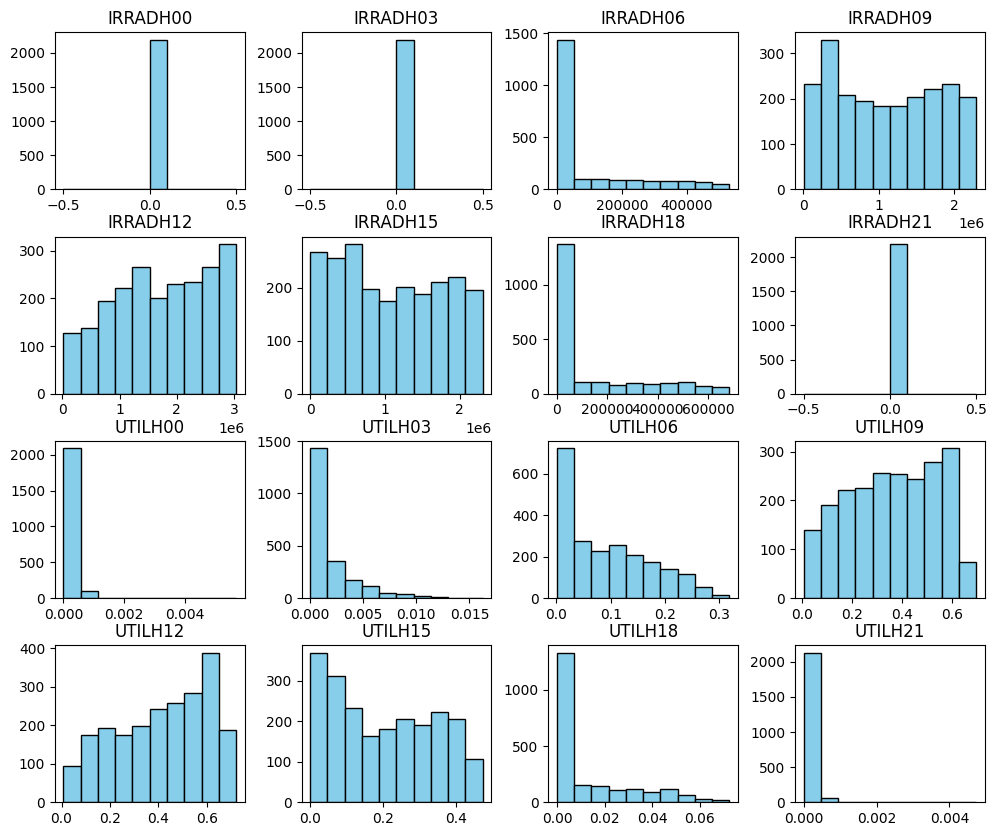

In [10]:
df2.hist(figsize=(12, 10), color='skyblue', edgecolor='black', grid=False)
plt.show()

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FECHA     2192 non-null   object  
 1   IRRADH00  2192 non-null   float64 
 2   IRRADH03  2192 non-null   float64 
 3   IRRADH06  2192 non-null   float64 
 4   IRRADH09  2192 non-null   float64 
 5   IRRADH12  2192 non-null   float64 
 6   IRRADH15  2192 non-null   float64 
 7   IRRADH18  2192 non-null   float64 
 8   IRRADH21  2192 non-null   float64 
 9   ANNO      2192 non-null   category
 10  MES       2192 non-null   category
 11  DIA       2192 non-null   category
 12  DIASEM    2192 non-null   category
 13  UTILH00   2192 non-null   float64 
 14  UTILH03   2192 non-null   float64 
 15  UTILH06   2192 non-null   float64 
 16  UTILH09   2192 non-null   float64 
 17  UTILH12   2192 non-null   float64 
 18  UTILH15   2192 non-null   float64 
 19  UTILH18   2192 non-null   float64 
 20  UTILH21 

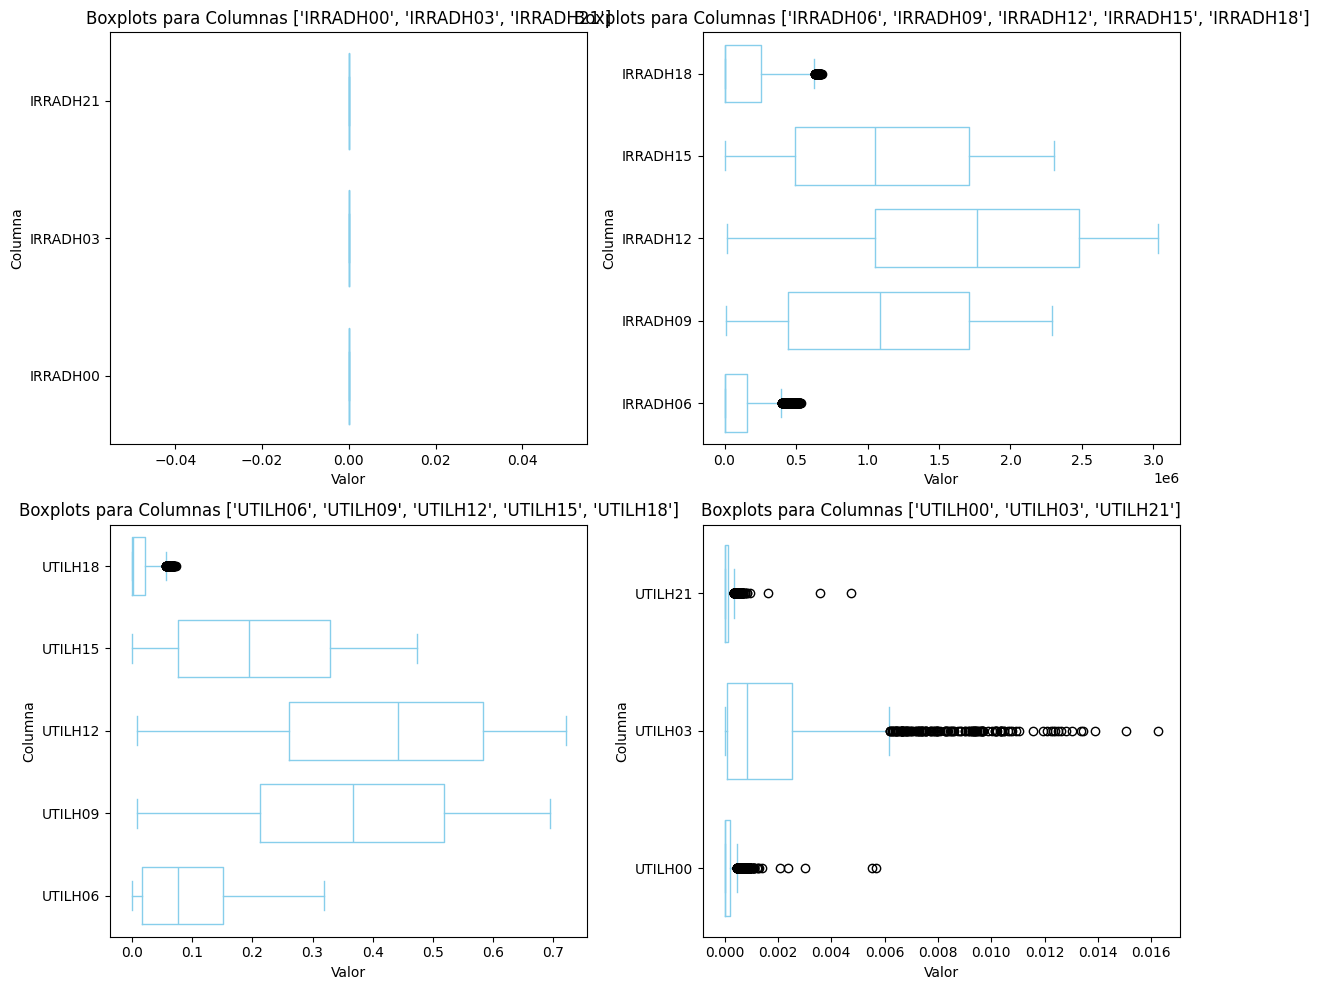

In [12]:
grupos_boxplot = [['IRRADH00', 'IRRADH03', 'IRRADH21'], ['IRRADH06', 'IRRADH09', 'IRRADH12', 'IRRADH15', 'IRRADH18'], 
                  ['UTILH06', 'UTILH09', 'UTILH12', 'UTILH15', 'UTILH18'], ['UTILH00', 'UTILH03', 'UTILH21']]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i in range(2):
    for j in range(2):
        grupo = grupos_boxplot[i * 2 + j]
        df_box = df2.loc[:, grupo]
        df_box.boxplot(ax=axes[i, j], grid=False, vert=False, color='skyblue', widths=0.7)
        axes[i, j].set_title(f'Boxplots para Columnas {grupo}')
        axes[i, j].set_ylabel('Columna')
        axes[i, j].set_xlabel('Valor')

plt.tight_layout()
plt.show()


No hay outliers claros. Como era de esperar, por las noches los valores son 0 (o prácticamente 0 en el caso de las utilizaciones horarias), y durante el día la distribución es similar para una agrupación horaria determinada tanto para la irradiación como para la utilización. Se podrían plantear transformaciones boxcox para buscar más normalidad en los datos, pero a priori no parece necesario.

También se comprueba que los valores de utilización están normalizados, tal y como establece su definición.

Quizás los únicos que llaman la atención son esos valores de utilización extrañamente altos para no haber irradiación (aunque siguen siendo muy bajos en comparación a los valores para las horas diurnas).

In [13]:
# Filtrar el DataFrame para incluir solo las columnas categóricas y la fecha
columnas_nonum = df2.select_dtypes(include=['category', 'object'])

# Obtener un resumen de información de las variables categóricas
columnas_nonum.describe()

FECHA  ANNO   MES   DIA  DIASEM
count         2192  2192  2192  2192    2192
unique        2192     6    12    31       7
top     2015-01-01  2016     1     1       3
freq             1   366   186    72     314

In [14]:
# Filtrar el DataFrame para incluir solo las columnas categóricas y la fecha
columnas_nonum = df2.select_dtypes(include=['category', 'object'])

# Obtener un resumen de información de las variables categóricas
columnas_nonum.describe()

FECHA  ANNO   MES   DIA  DIASEM
count         2192  2192  2192  2192    2192
unique        2192     6    12    31       7
top     2015-01-01  2016     1     1       3
freq             1   366   186    72     314

In [15]:
columnas_categoricas = df2.select_dtypes(include=['category'])

cabeceras = columnas_categoricas.columns.tolist()

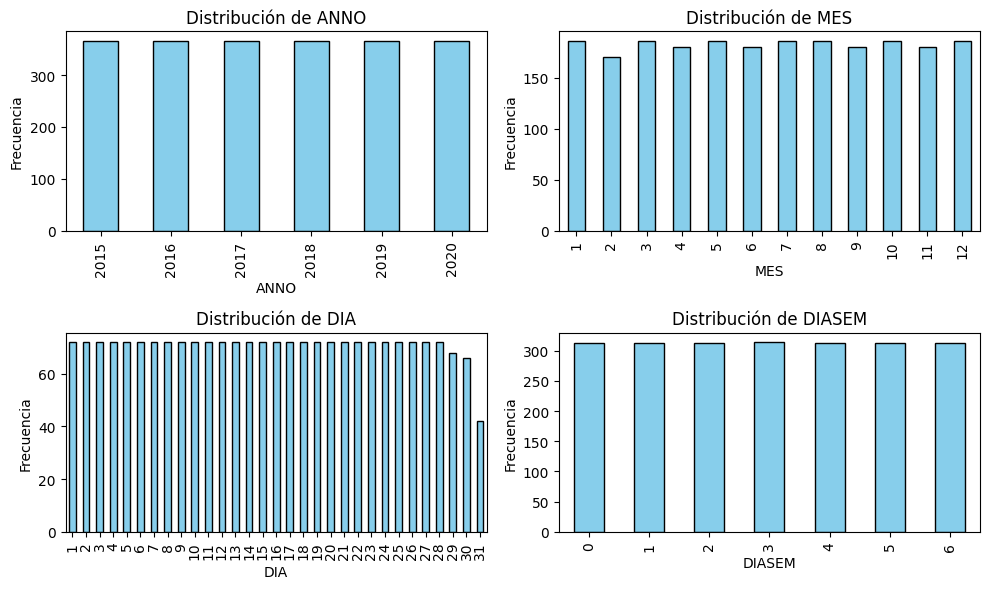

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, var in enumerate(cabeceras):
    # Obtener recuentos de valores ordenados
    value_counts_sorted = df2[var].value_counts().sort_index()
    
    # Trazar el gráfico con los valores ordenados
    value_counts_sorted.plot(kind='bar', ax=axes[i//2, i%2], color='skyblue', edgecolor='black')
    axes[i//2, i%2].set_title(f'Distribución de {var}')
    axes[i//2, i%2].set_xlabel(var)
    axes[i//2, i%2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


Las variables categóricas tampoco muestran un comportamiento anómalo.

Haciendo esta primera exploración, y sabiendo que se busca predecir el valor de la utilización horaria en función de la irradiación y el resto de predictores, aparece la necesidad de formatear nuestro conjunto de datos para que sea más cómodo y fácil de tratar. Además, es lógico no poder usar como predictor la irradiación de un grupo horario determinado para una utilización de un grupo horario anterior. Por ello, sse crea un predictor llamado grupo horario, y se juntan las 8 variables de irradiación y utilización en 1 única para cada una.

In [8]:
# Crear una lista para almacenar los datos
data = []

# Suponiendo que tienes un DataFrame llamado df con la estructura dada

# Iterar sobre cada día en el DataFrame original
for idx, row in df2.iterrows():
    fecha = row['FECHA']
    anno = row['ANNO']
    mes = row['MES']
    dia = row['DIA']
    diasem = row['DIASEM']
    
    # Iterar sobre cada grupo horario en el día
    for hora in range(0, 24, 3):
        grupo = hora // 3 * 3
        irradiancia = row[f'IRRADH{hora:02d}']
        utilidad = row[f'UTILH{hora:02d}']
        
        # Agregar los datos a la lista
        data.append([fecha, anno, mes, dia, diasem, grupo, irradiancia, utilidad])

# Crear el DataFrame a partir de la lista de datos
df = pd.DataFrame(data, columns=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH', 'IRRAD', 'UTIL'])

# Visualizar el nuevo DataFrame
print(df.head())

        FECHA  ANNO  MES  DIA  DIASEM  GH       IRRAD      UTIL
0  2015-01-01  2015    1    1       3   0        0.00  0.000000
1  2015-01-01  2015    1    1       3   3        0.00  0.000000
2  2015-01-01  2015    1    1       3   6        0.00  0.032237
3  2015-01-01  2015    1    1       3   9   393513.78  0.370669
4  2015-01-01  2015    1    1       3  12  1228750.10  0.468188


In [9]:
# Data describe
df.describe()

ANNO           MES           DIA        DIASEM           GH  \
count  17536.000000  17536.000000  17536.000000  17536.000000  17536.00000   
mean    2017.500456      6.521898     15.732664      3.000000     10.50000   
std        1.708230      3.449085      8.801621      1.999601      6.87406   
min     2015.000000      1.000000      1.000000      0.000000      0.00000   
25%     2016.000000      4.000000      8.000000      1.000000      5.25000   
50%     2017.500000      7.000000     16.000000      3.000000     10.50000   
75%     2019.000000     10.000000     23.000000      5.000000     15.75000   
max     2020.000000     12.000000     31.000000      6.000000     21.00000   

              IRRAD          UTIL  
count  1.753600e+04  17536.000000  
mean   5.170120e+05      0.135889  
std    7.842147e+05      0.192569  
min    0.000000e+00      0.000000  
25%    0.000000e+00      0.000121  
50%    0.000000e+00      0.016260  
75%    8.223137e+05      0.233782  
max    3.033988e+06      0.720680

Repetimos brevemente los pasos para el nuevo dataframe, comprobando que todo sea correcto y no haya comportamientos anómalos.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   17536 non-null  object 
 1   ANNO    17536 non-null  int64  
 2   MES     17536 non-null  int64  
 3   DIA     17536 non-null  int64  
 4   DIASEM  17536 non-null  int64  
 5   GH      17536 non-null  int64  
 6   IRRAD   17536 non-null  float64
 7   UTIL    17536 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 1.1+ MB


In [10]:
# Convertir las columnas en categorías
df['ANNO'] = df['ANNO'].astype('category')
df['MES'] = df['MES'].astype('category')
df['DIA'] = df['DIA'].astype('category')
df['DIASEM'] = df['DIASEM'].astype('category')
df['GH'] = df['GH'].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   FECHA   17536 non-null  object  
 1   ANNO    17536 non-null  category
 2   MES     17536 non-null  category
 3   DIA     17536 non-null  category
 4   DIASEM  17536 non-null  category
 5   GH      17536 non-null  category
 6   IRRAD   17536 non-null  float64 
 7   UTIL    17536 non-null  float64 
dtypes: category(5), float64(2), object(1)
memory usage: 499.3+ KB


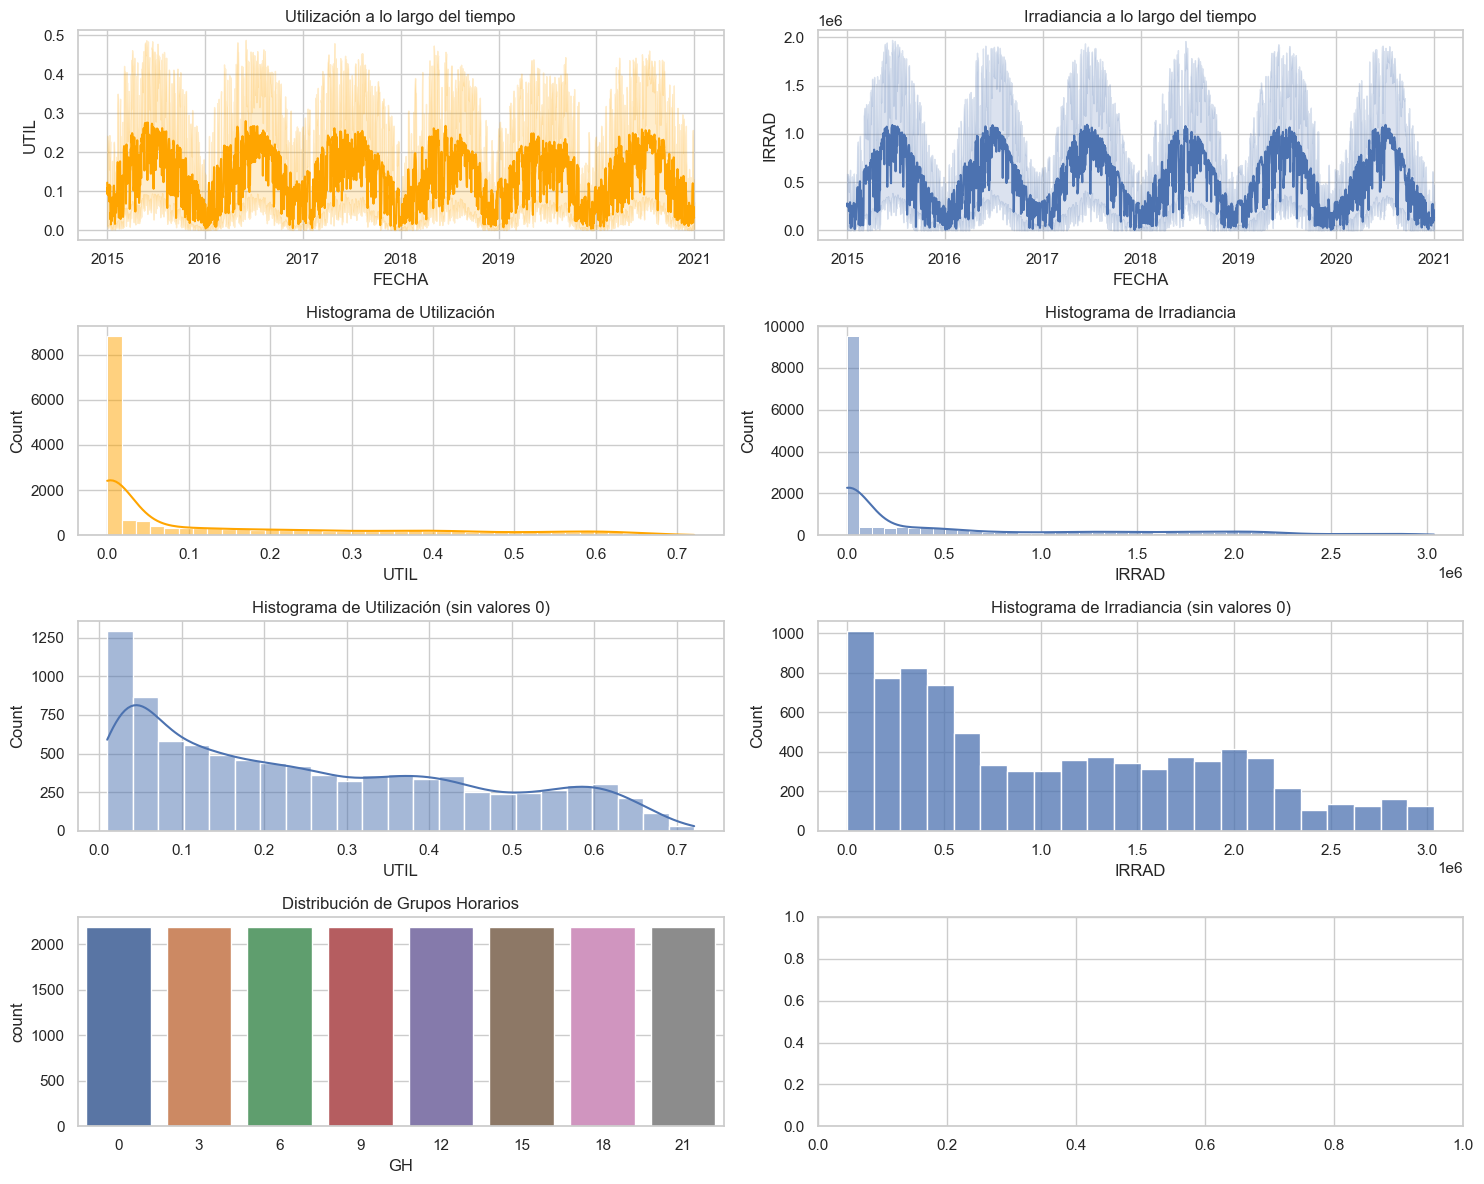

In [22]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear un nuevo conjunto de ejes (subplots)
fig, axs = plt.subplots(4, 2, figsize=(15, 12))


# Gráfico de línea temporal para la variable IRRAD
sns.lineplot(data=df, x='FECHA', y='IRRAD', ax=axs[0, 1])
axs[0, 1].set_title('Irradiancia a lo largo del tiempo')

# Histograma para la variable IRRAD
sns.histplot(data=df, x='IRRAD', ax=axs[1, 1], kde=True)
axs[1, 1].set_title('Histograma de Irradiancia')

# Histograma para la variable IRRAD sin valores iguales a 0
sns.histplot(data=df[df['IRRAD'] != 0], x='IRRAD', ax=axs[2, 1])
axs[2, 1].set_title('Histograma de Irradiancia (sin valores 0)')

# Gráfico de línea temporal para la variable UTIL
sns.lineplot(data=df, x='FECHA', y='UTIL', ax=axs[0, 0], color='orange')
axs[0, 0].set_title('Utilización a lo largo del tiempo')

# Histograma para la variable UTIL
sns.histplot(data=df, x='UTIL', ax=axs[1, 0], kde=True, color='orange')
axs[1, 0].set_title('Histograma de Utilización')

# Histograma para la variable UTIL sin valores iguales o muy cercanos a 0
sns.histplot(data=df[df['UTIL'] > 0.01], x='UTIL', ax=axs[2, 0], kde=True)
axs[2, 0].set_title('Histograma de Utilización (sin valores 0)')


# Gráfico de barras para los grupos horarios
sns.countplot(data=df, x='GH', ax=axs[3, 0])
axs[3, 0].set_title('Distribución de Grupos Horarios')

# Eliminar el espacio en blanco entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

En efecto, el comportamiento es el esperado, por lo que se continúa con la siguiente etapa del EDA.

### 4. Análisis Exploratorio

Se comienza viendo un gráfico conjunto de relaciones entre todos los pares de variables.

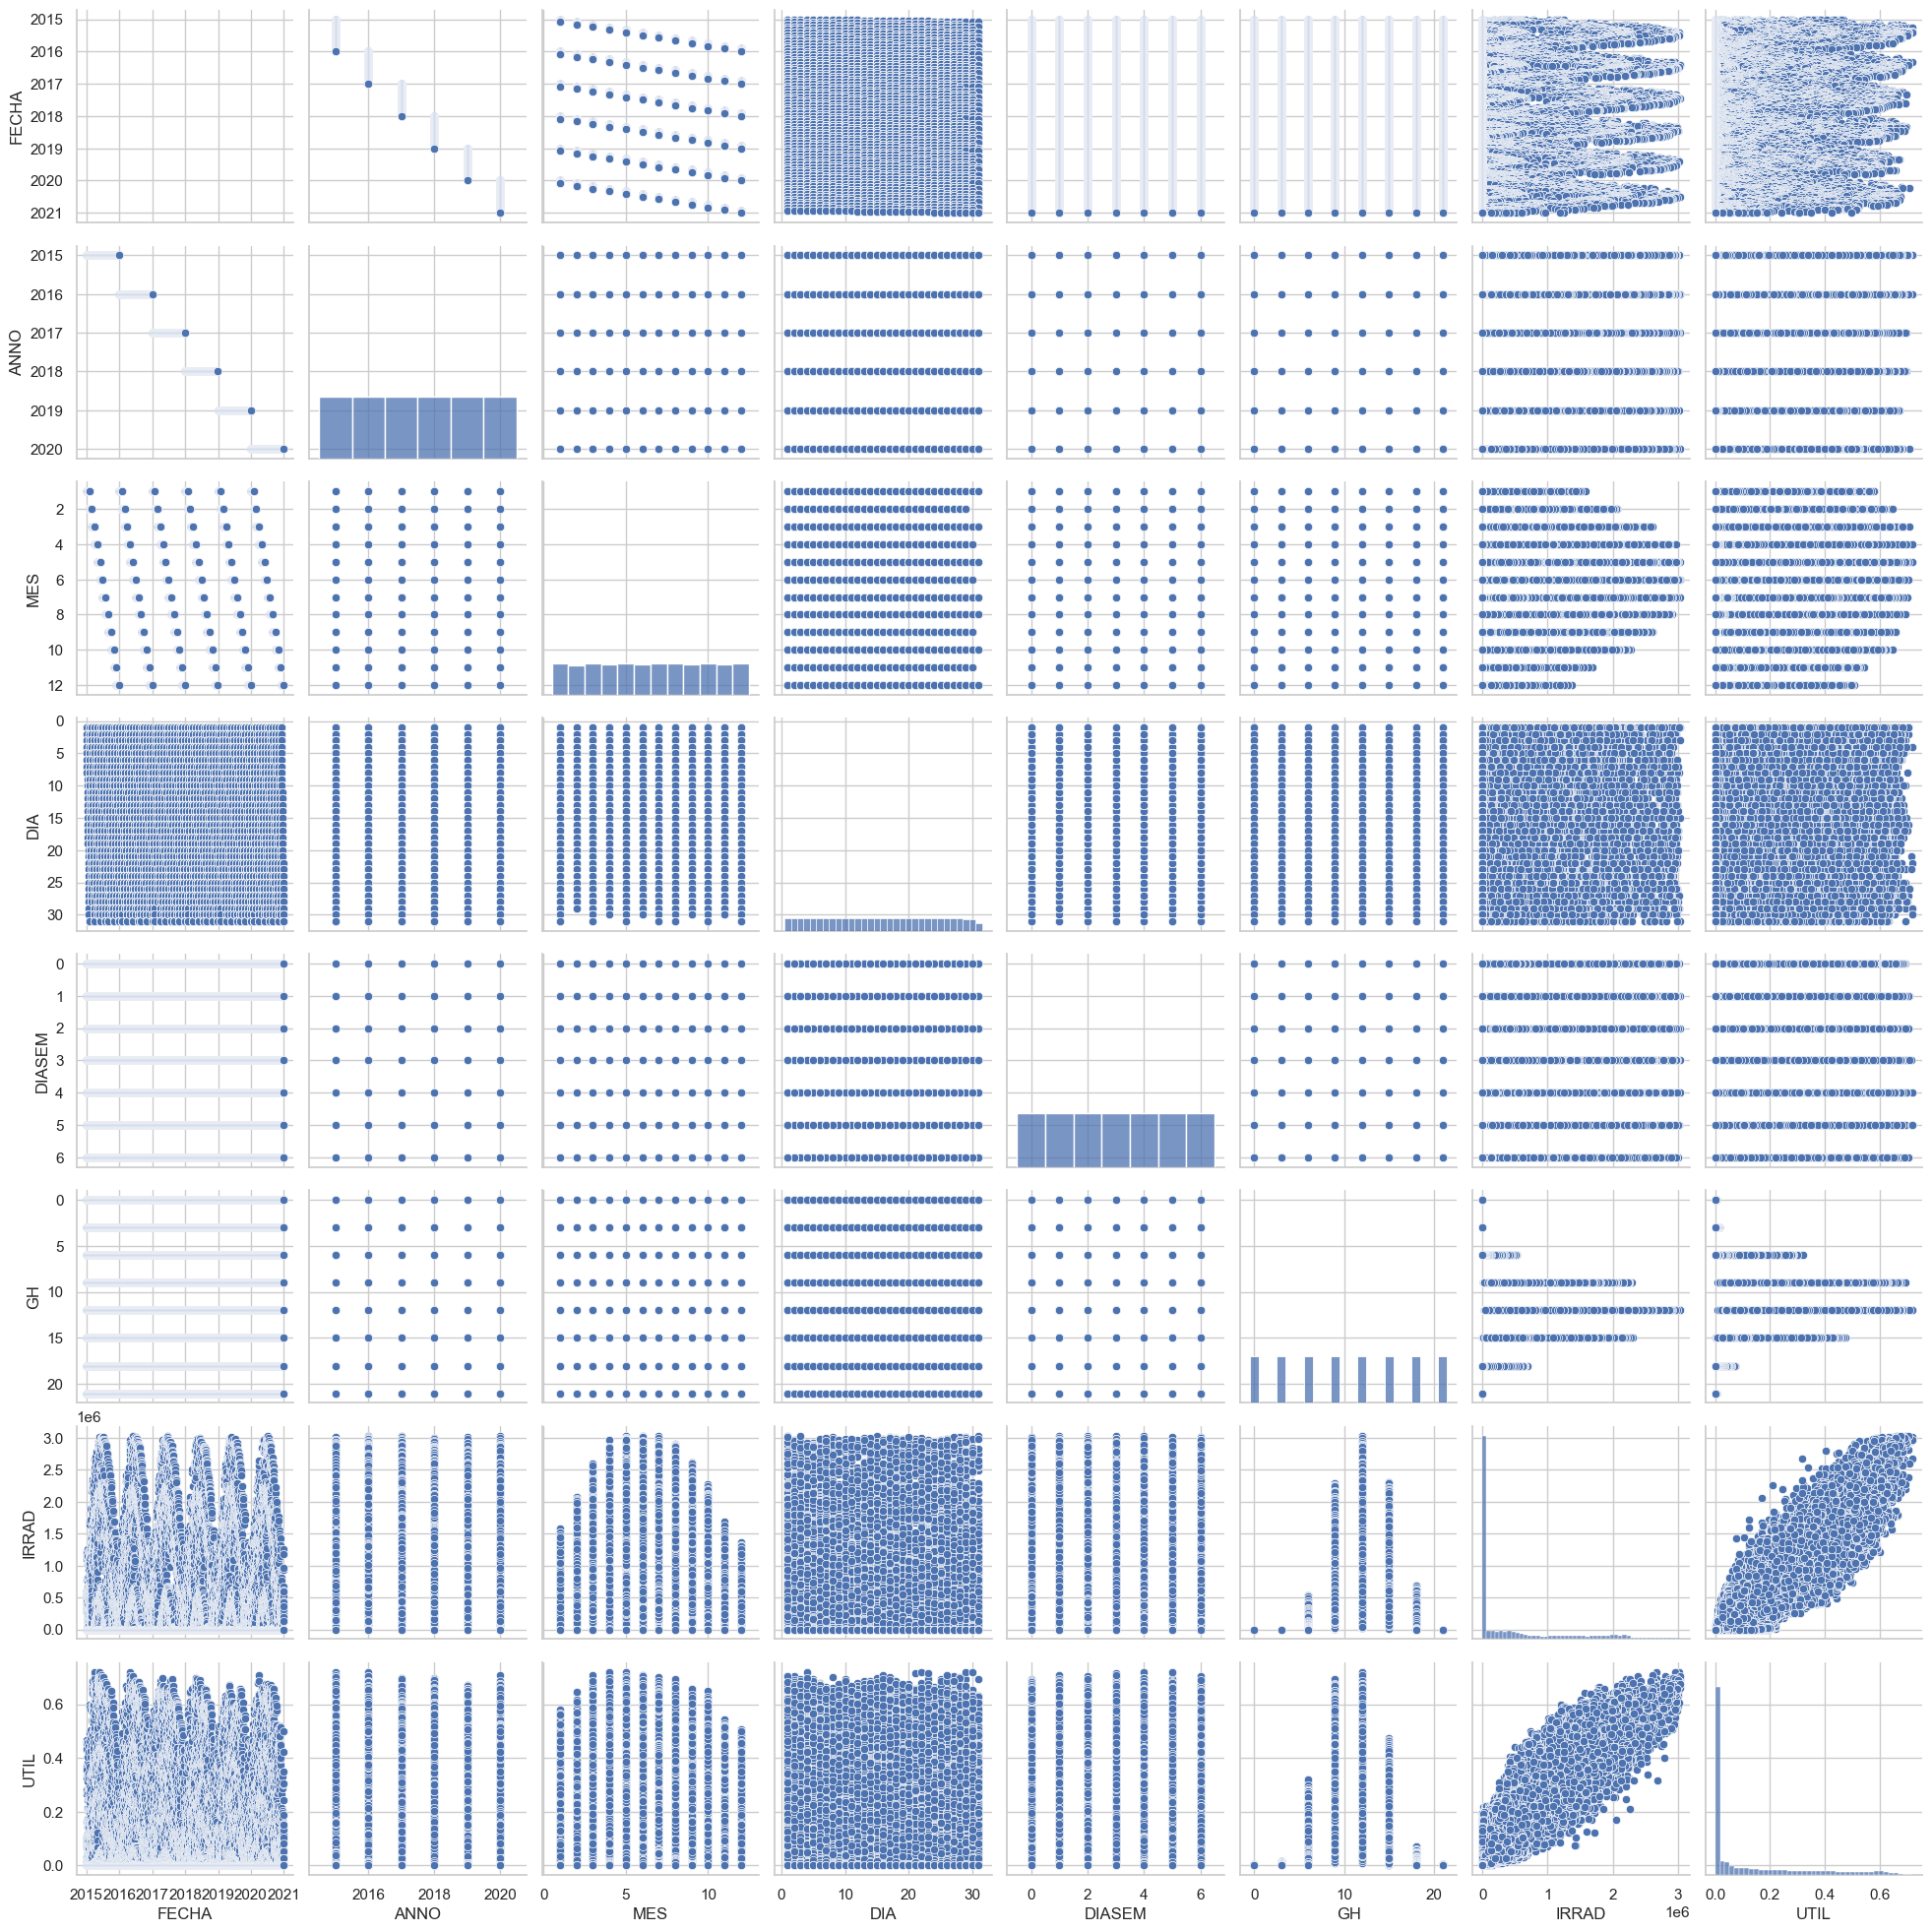

In [23]:
# Trazar el pairplot con las variables 
sns.pairplot(df, vars=df.columns.values.tolist())
plt.show()

Como era de esperar, tanto la irradiación como la utilización siguen patrones similares, donde principalmente afecta la fecha (en concreto, el mes), y el grupo horario. Además, ambas se relacionan de forma lineal. De nuevo, el comportamiento es generalmente el esperado.

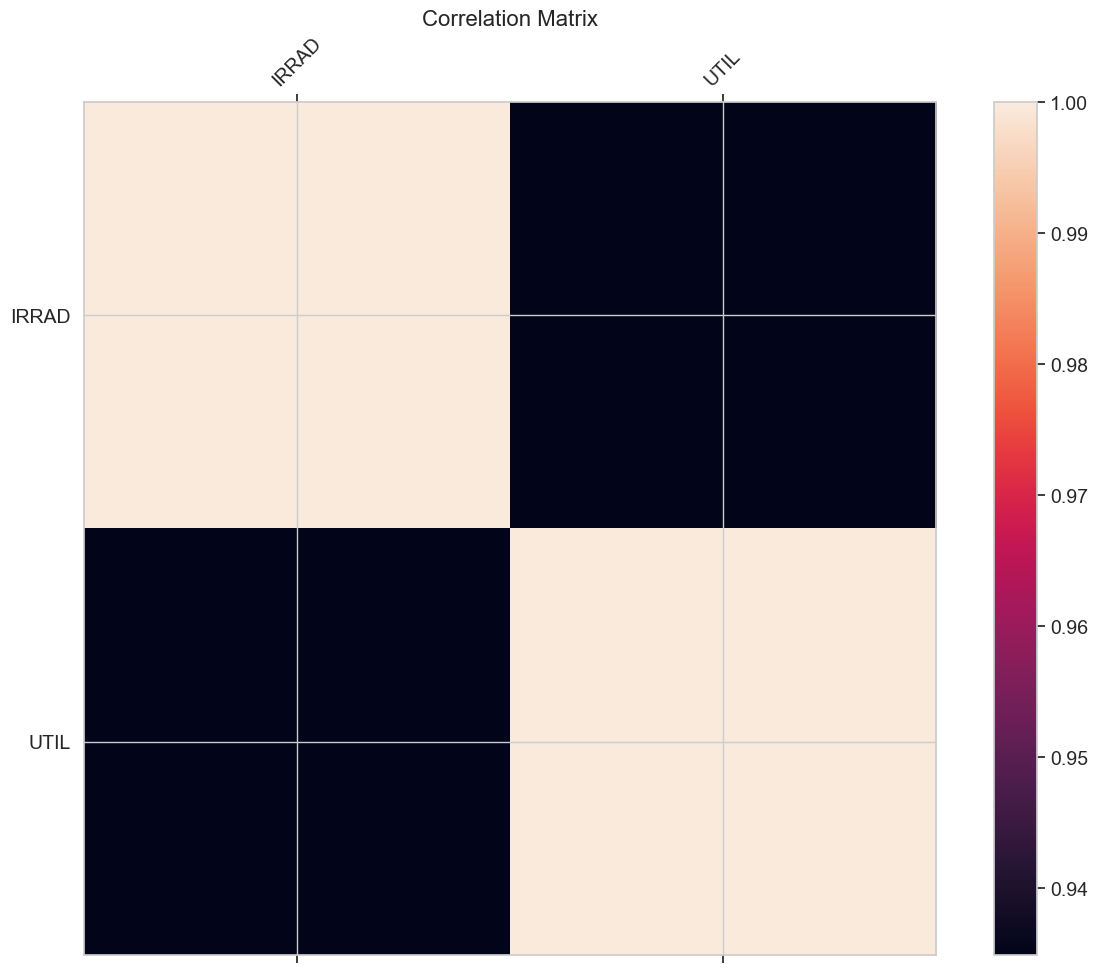

In [29]:
#correlation plot of numeric variables
f = plt.figure(figsize=(15, 11))
plt.matshow(df.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Las correlaciones son las ya esperadas y comentadas anteriormente. Para los valores de irradiación nulos no aplica, ya que son siempre 0.

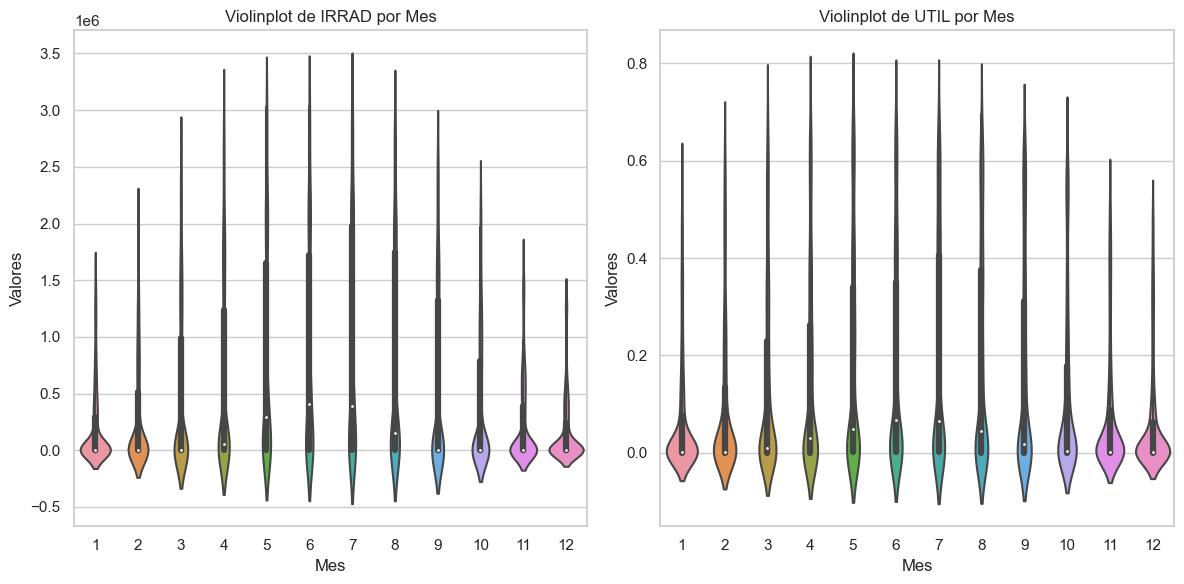

In [30]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='MES', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Mes')
    axs[col].set_xlabel('Mes')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

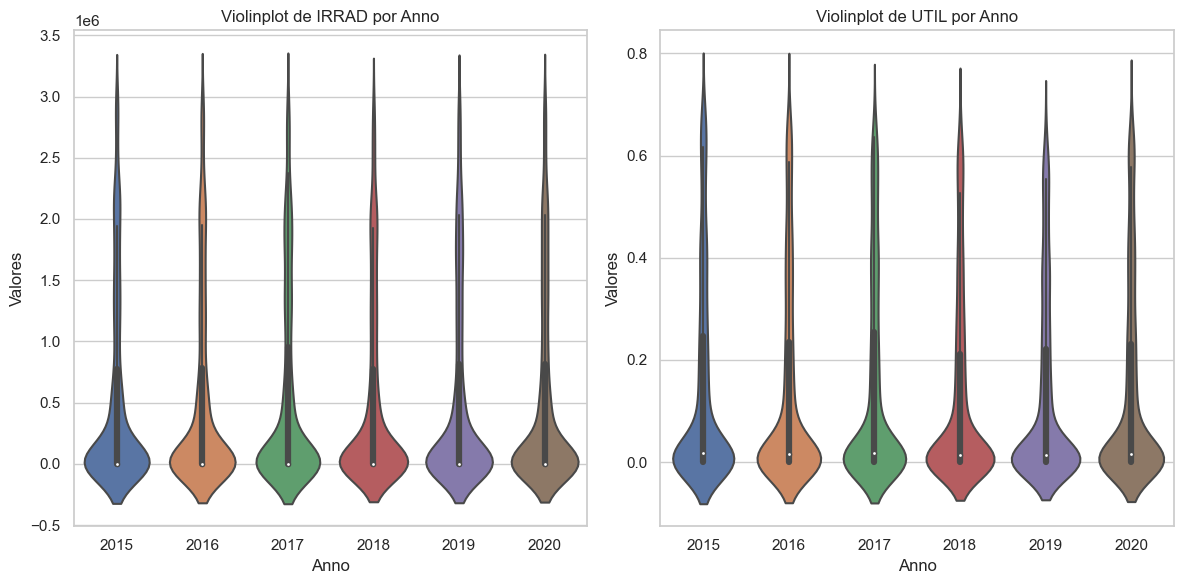

In [31]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='ANNO', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Anno')
    axs[col].set_xlabel('Anno')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

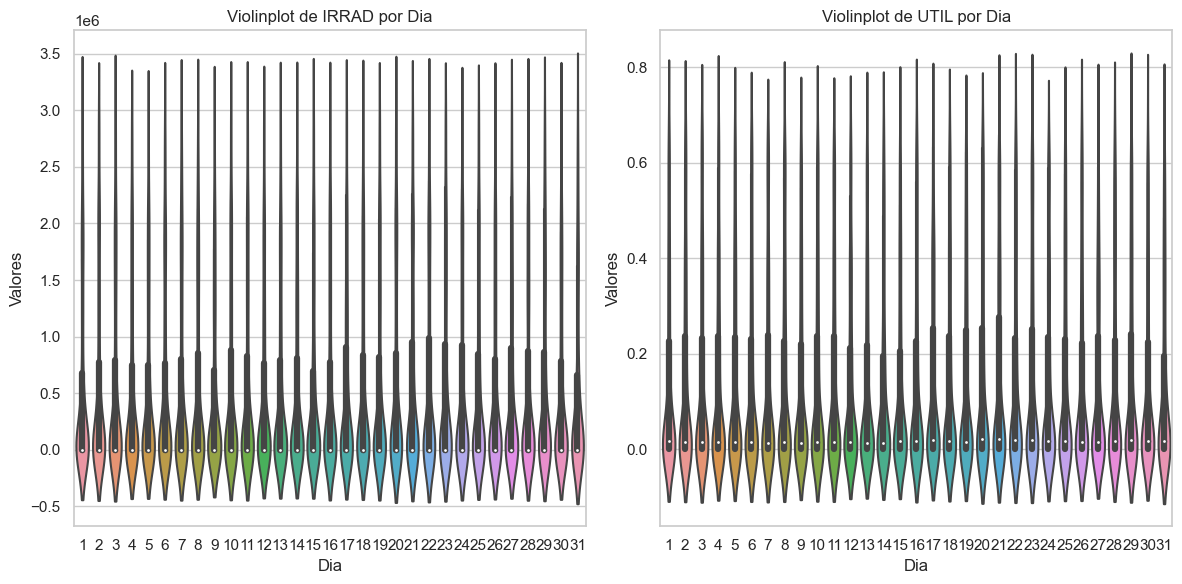

In [32]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='DIA', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Dia')
    axs[col].set_xlabel('Dia')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

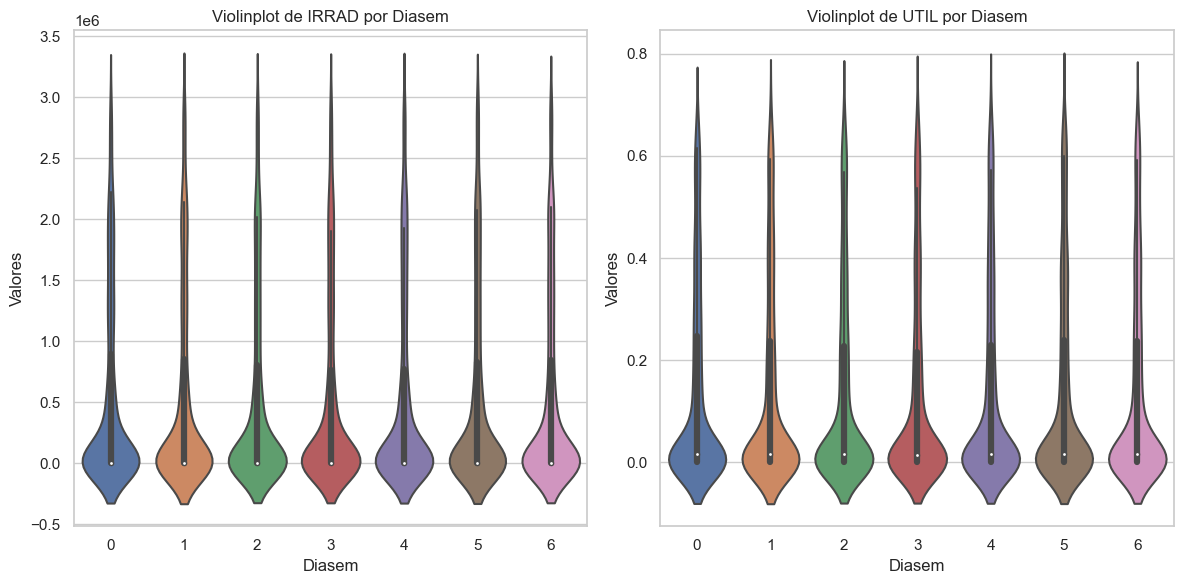

In [33]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='DIASEM', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Diasem')
    axs[col].set_xlabel('Diasem')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

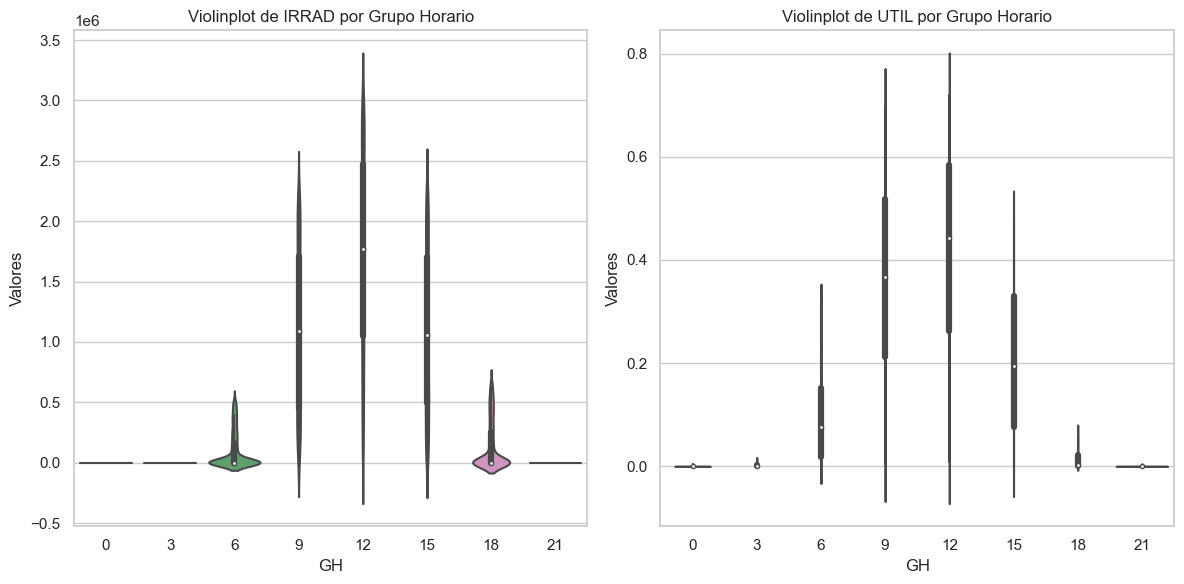

In [34]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='GH', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Grupo Horario')
    axs[col].set_xlabel('GH')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

En efecto se comprueba que las únicas variables que parecen afectar a las utilizaciones son el mes, el grupo horario y las irradiaciones, tal y como se esperaba.

Por último, se comprueba como la relación entre la utilización en una hora determinada y su irradiación es lineal, junto a la diferencia en la relación según el mes y grupo horario.

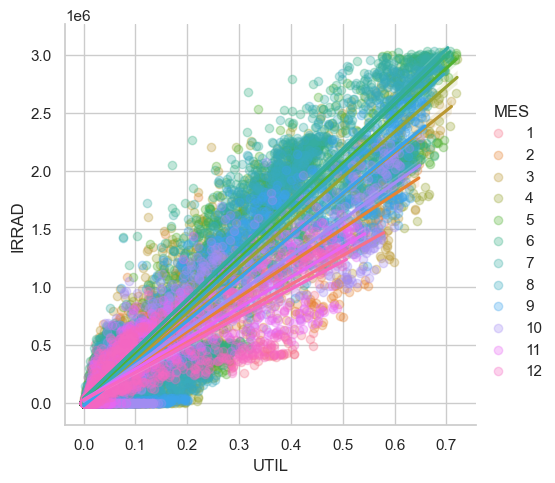

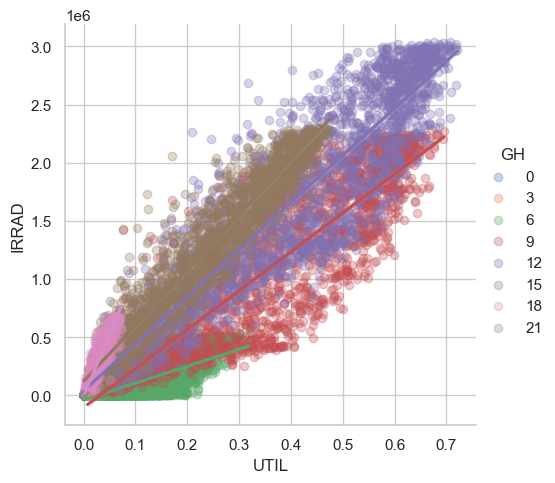

In [35]:
sns.lmplot(x='UTIL', y='IRRAD', hue='MES', data=df, scatter_kws={'alpha':0.3})
plt.show()
sns.lmplot(x='UTIL', y='IRRAD', hue='GH', data=df, scatter_kws={'alpha':0.3})
plt.show()

Esto demuestra la necesidad de que ambas variables se encuentren en cualquiera de los modelos a realizar (se puede ver la gran diferencia que hay entre el grupo horario 6, 18, 0, 3, 21 y 12, por ejemplo).

### 5. Desbalance de Clases

In [36]:
# Ya se ha comprobado anteriormente que no hay desbalances en las variables categóricas.

### 5. División del Dataset en Train y Test

En nuestro caso, dado que tenemos suficiente profundidad de datos (más de 17000), podemos realizar la siguiente división:

 + Train: **60%** de los datos. Ahí se encuentran también los datos de validación que se utilizan en k-fold cross validation para el grid search. Más de 10000 observaciones.

 + AdjTest: **20%** de los datos, llamados adjusting test. Sirven para comprobar los resultados de nuestros modelos, hacer pequeñas modificaciones y escoger el modelo que creamos que mejor predice y generaliza.

 + Test: **20%** de los datos. Este conjunto a priori no lo tendríamos, por lo que debe estar guardado y no usarse hasta que no se tenga decidido el modelo final, el que nosotros creamos que es el mejor. Sirve únicamente para ver si estábamos en lo cierto, o en qué hemos fallado, pero una vez se mira el desempeño del modelo en este conjunto de datos, no se puede volver a tocar nada del modelo.

In [11]:
INPUTS = df.columns[df.columns != 'UTIL']
OUTPUT = 'UTIL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,  #percentage of test data
                                                    random_state=0) #seed for replication

# Split
X_AdjTest, X_Test, y_AdjTest, y_Test = train_test_split(X_test, y_test,
                                                    test_size=0.5,  #percentage of adjusting test data
                                                    random_state=0) #seed for replication

X_train.head()

FECHA  ANNO MES DIA DIASEM  GH      IRRAD
8264  2017-10-30  2017  10  30      0   0        0.0
6680  2017-04-15  2017   4  15      5   0        0.0
1326  2015-06-15  2015   6  15      0  18   526790.3
2187  2015-10-01  2015  10   1      3   9  1512109.1
2063  2015-09-15  2015   9  15      1  21        0.0

In [12]:
## Create dataset to store model predictions (as we said, the test dataset is not used anymore)
dfTR_eval = X_train.copy()
dfTR_eval['UTIL'] = y_train
dfTS_eval = X_AdjTest.copy()
dfTS_eval['UTIL'] = y_AdjTest

## PASO 2: ANÁLISIS PREVIO

Antes de proceder a la creación de diversos modelos utilizando técnicas de ensamblado, puede ser recomendable realizar un pequeño análisis con diversas técnicas como clustering, que nos podría ayudar a distinguir agrupaciones de los datos que se distribuyan o tengan una relación distinta, siendo necesaria la creación de modelos distintos para cada uno de esos clústers.

### 1. Clustering

In [15]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.cluster.vq import vq
from sklearn.mixture import GaussianMixture

# Other
from mltools import unsupervised_tools as UT

In [27]:
X_train_copy = X_train.copy()
X_train_copy = X_train_copy.iloc[:,1:]

# Seleccionar todas las columnas de tipo category
category_columns = X_train_copy.select_dtypes(include=['object', 'category']).columns.tolist()

# Crear las dummies
dummies_df = pd.get_dummies(X_train_copy[category_columns], drop_first=True)

In [28]:
# Convertir True/False a 0/1
dummies_df = dummies_df.astype(int)

# Crear una copia del DataFrame original sin las variables categóricas
X_train_copy = X_train.iloc[:,1:].drop(columns=category_columns)

# Concatenar las columnas dummy al DataFrame original
X_train_encoded = pd.concat([X_train_copy, dummies_df], axis=1)

In [29]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X=X_train_encoded)

#### Hierarchical

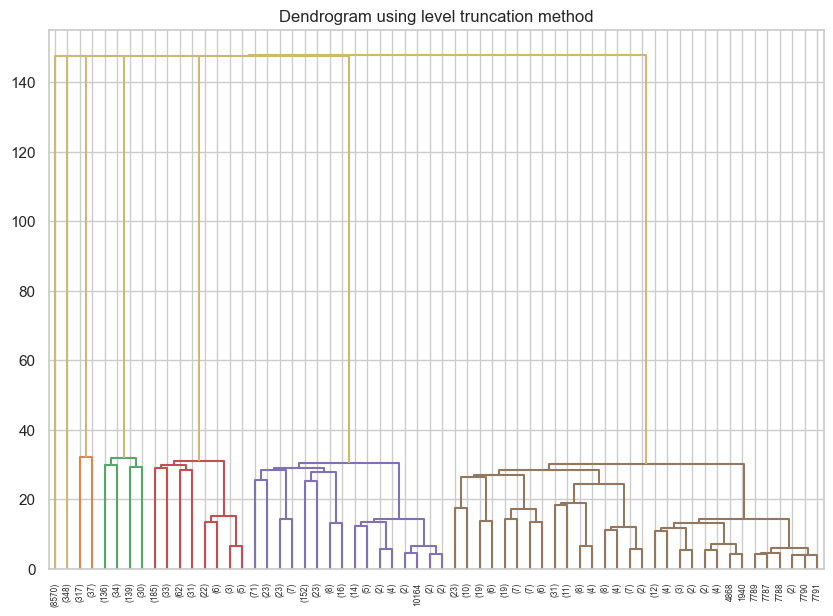

In [43]:
## Hierarchical clustering -------------------------------------------------------------------------------------------------------
# hierarchical clustering
linked = linkage(X_transformed, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=X_train_encoded.index,
            truncate_mode= 'level', # Type of truncation, in this case number of levels. A “level” includes all nodes with p merges from the last merge.
            p = 5, # Number of leaves to show
            above_threshold_color='y',
            color_threshold=100,
            distance_sort='descending',
            show_leaf_counts=True)
plt.gca().set_title('Dendrogram using level truncation method')
plt.show()

The average silhouette_score is : 0.06673499590284303


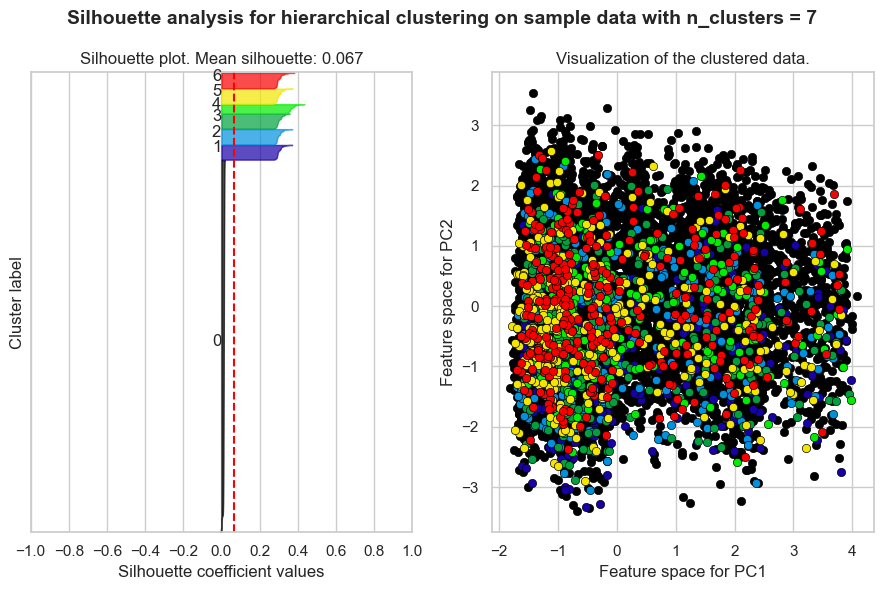

In [44]:
## Silhouette method ---------------
# Cut dendrogram tree by number of clusters
n_clusters = 7
cluster_labels = cut_tree(linked, n_clusters=n_clusters)
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X_transformed, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)

#Represent clusters
UT.plot_clusters(X_train_encoded, cluster_labels, alpha_curves=0.3, figsize=(9,6))

#### Kmeans

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

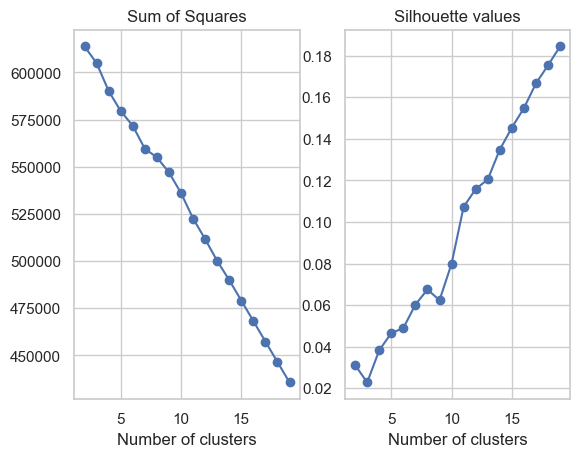

In [39]:
## K_means and silhouette method simultaneously with different number of clusters
range_n_clusters = list(range(2,20))
SSQ = []
sil_avg = []
plot = False
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_transformed)

    #Obtain Reconstruction error
    _ , err = vq(X_transformed, clusterer.cluster_centers_)
    SSQ.append(np.sum(err**2))
    #Obtain silhouette
    sil_avg.append(silhouette_score(X_transformed, cluster_labels))
    if plot:
        UT.plot_clusters(X_train_encoded, cluster_labels, centers=clusterer.cluster_centers_, figsize=(6,4))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range_n_clusters,SSQ, marker='o')
ax1.set_title("Sum of Squares")
ax1.set_xlabel("Number of clusters")
ax2.plot(range_n_clusters,sil_avg, marker='o')
ax2.set_title("Silhouette values")
ax2.set_xlabel("Number of clusters")
plt.show()

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters specifying number of clusters:
   # Samples
0       3876
1       2252
2       4393
The average silhouette_score is : 0.022758195498671724


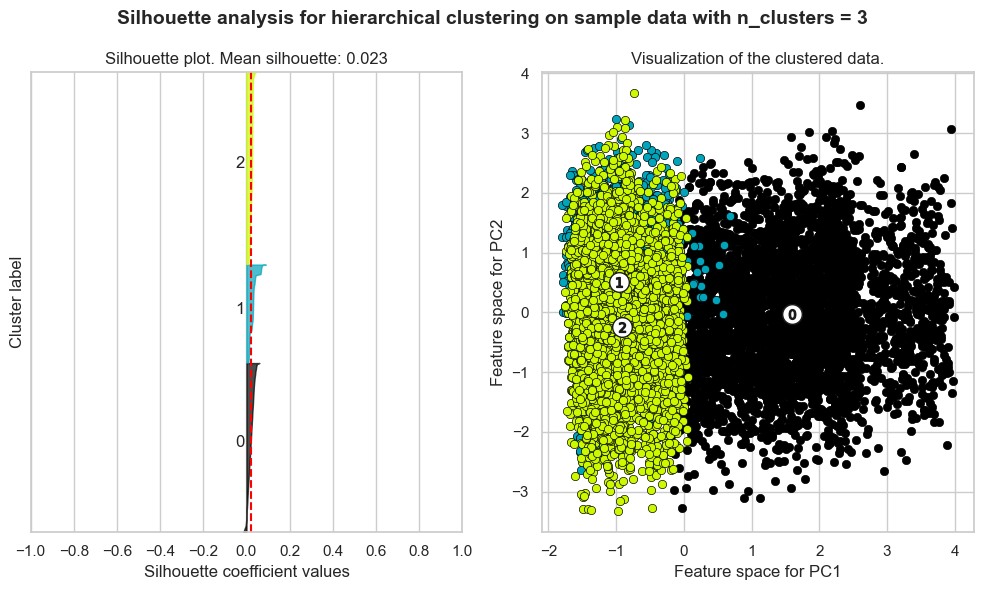

In [40]:
# Fit final model and validate
clusterer = KMeans(n_clusters=3, random_state=10)
#Predict on training dataset
cluster_knn = clusterer.fit_predict(X_transformed)
# Cut dendrogram tree by number of clusters
print('Clusters specifying number of clusters:')
unique, counts = np.unique(cluster_knn, return_counts=True)
print(pd.DataFrame(np.asarray(counts), index=unique, columns=['# Samples']))

# Silhouette
silhouette_avg = silhouette_score(X_transformed, cluster_knn)
print("The average silhouette_score is :", silhouette_avg)

# Plot clustering classification
UT.plot_clusters(X_train_encoded, cluster_knn, centers= scaler.inverse_transform(clusterer.cluster_centers_), figsize=(10,6))

#### Gaussian Mixture Models

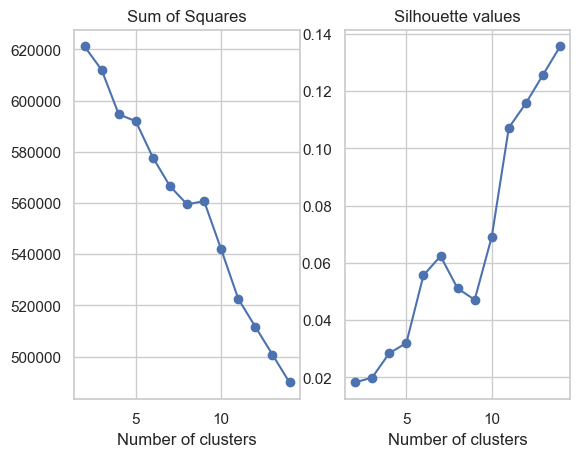

In [41]:
## K_means and silhouette method simultaneously with different number of clusters
range_n_clusters = list(range(2,15))
SSQ = []
sil_avg = []
cv_type = 'full'
for n_clusters in range_n_clusters:
    # fit model
    clusterer = GaussianMixture(n_components=n_clusters,
                              covariance_type=cv_type,
                              random_state=10)
    cluster_labels = clusterer.fit_predict(X_transformed)

    #Obtain Reconstruction error
    _ , err = vq(X_transformed, clusterer.means_)
    SSQ.append(np.sum(err**2))
    #Obtain silhouette
    sil_avg.append(silhouette_score(X_transformed, cluster_labels))
    if plot:
        UT.plot_clusters(X_train_encoded, cluster_labels, centers=clusterer.means_, figsize=(6,4))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range_n_clusters,SSQ, marker='o')
ax1.set_title("Sum of Squares")
ax1.set_xlabel("Number of clusters")
ax2.plot(range_n_clusters,sil_avg, marker='o')
ax2.set_title("Silhouette values")
ax2.set_xlabel("Number of clusters")
plt.show()

Clusters specifying number of clusters:
   # Samples
0       3876
1       2252
2       4393
The average silhouette_score is : 0.022758195498671724


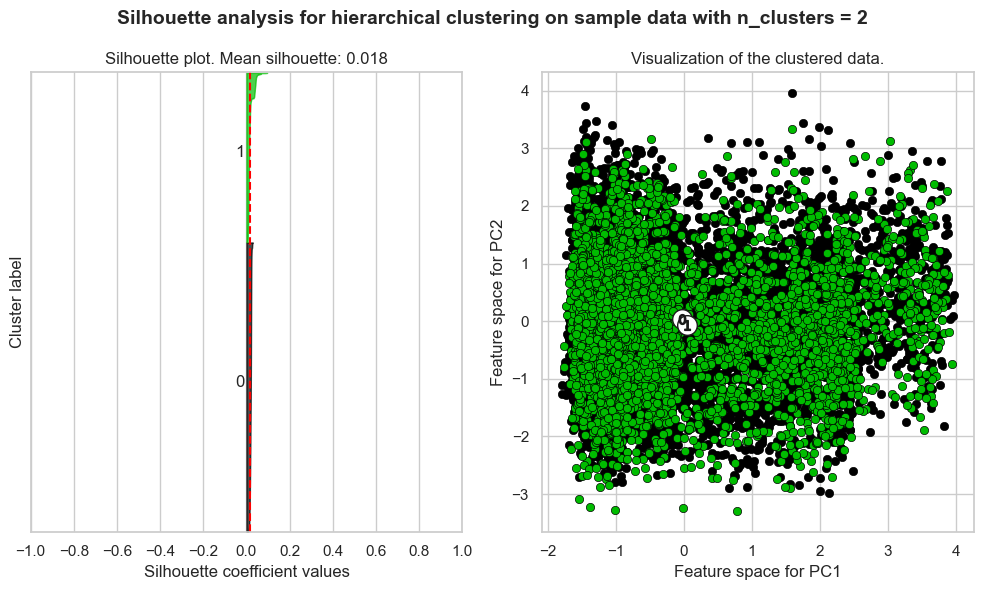

In [42]:
# Fit final model and validate
clusterer_GMM = GaussianMixture(n_components=2,
                              covariance_type='full',
                              random_state=10)
#Predict on training dataset
cluster_GMM = clusterer_GMM.fit_predict(X_transformed)
# Cut dendrogram tree by number of clusters
print('Clusters specifying number of clusters:')
unique, counts = np.unique(cluster_knn, return_counts=True)
print(pd.DataFrame(np.asarray(counts), index=unique, columns=['# Samples']))

# Silhouette
silhouette_avg = silhouette_score(X_transformed, cluster_knn)
print("The average silhouette_score is :", silhouette_avg)

# Plot clustering classification
UT.plot_clusters(X_train_encoded, cluster_GMM, centers= scaler.inverse_transform(clusterer_GMM.means_), figsize=(10,6))

Tras un ligero análisis no hay evidencias suficientes que nos indiquen que sea necesaria la división del conjunto de datos en clústers distintos, ya que todos los métodos consiguen resultados muy pobres desde las 2 hasta las 15 agrupaciones. Por tanto, se trabajará con el conjunto de datos de entrenamiento al completo para hacer un único modelo.

### 2. PDF

### 3. Bootstrap

## PASO 3: MODELOS

In [13]:
X_train.drop(columns=["FECHA"], inplace=True)
X_AdjTest.drop(columns=["FECHA"], inplace=True)
X_test.drop(columns=["FECHA"], inplace=True)

### 3.1 Standard tree

El Árbol de Regresión Estándar representa un modelo fundamental en el estudio de la predicción de la utilización solar en base a la irradiación solar. Este enfoque permite analizar cómo principalmente la radiación directa impacta en la capacidad de aprovechamiento de la energía solar.

In [14]:
#standard tree
param = {'DT__min_impurity_decrease': np.arange(0, 0.1 ,0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': [10], # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(2,30,1)} 

pipe = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                     random_state=0))]) # For replication

nFolds = 10
single_reg_tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_absolute_error',
                       cv=nFolds) # Number of Folds 

single_reg_tree_fit.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.0...
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099]),
                         'DT__min_samples_leaf': [10],
                         'DT__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             scoring='neg_mean_absolute_error')

In [20]:
INPUTS = X_train.columns

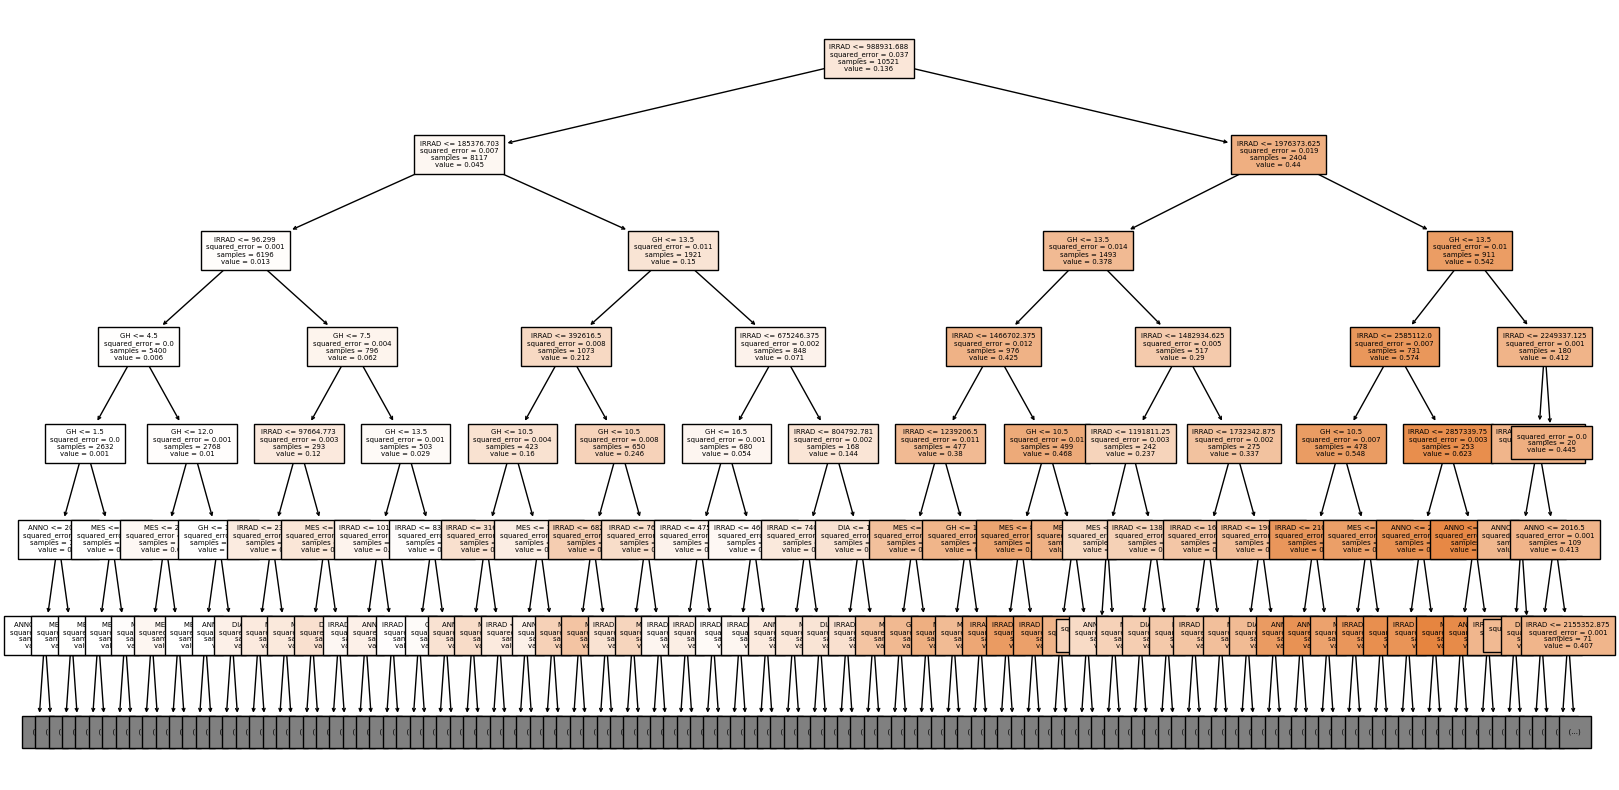

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(single_reg_tree_fit.best_estimator_['DT'],
          feature_names=INPUTS.tolist() ,
          class_names= [str(s) for s in y.unique()],
          fontsize=5, filled=True, max_depth=6)
plt.show()



[0 1 2 3 4 5]
['ANNO', 'MES', 'DIA', 'DIASEM', 'GH', 'IRRAD']


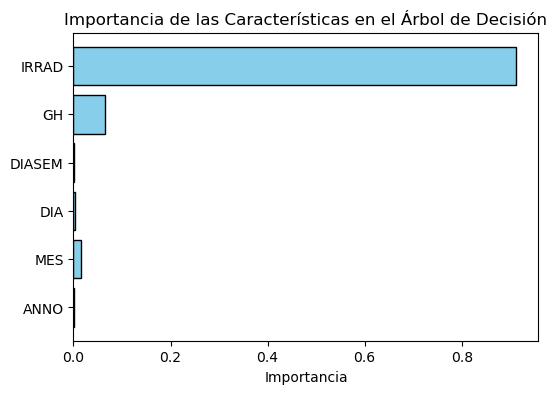

In [26]:
feature_importances = single_reg_tree_fit.best_estimator_['DT'].feature_importances_

# Nombres de las características, asegurándose de convertirlas a lista si aún no lo son
feature_names = INPUTS.tolist()

# Crear las barras del gráfico
y_pos = np.arange(len(feature_names))

print(y_pos)
print(feature_names)

# Crear el gráfico de barras
plt.figure(figsize=(6, 4))
plt.barh(y_pos, feature_importances, align='center', color="skyblue", edgecolor='black')
plt.yticks(y_pos, feature_names)
plt.xlabel('Importancia')
plt.title('Importancia de las Características en el Árbol de Decisión')

# Mostrar el gráfico
plt.show()

In [18]:
#show best params
print(single_reg_tree_fit.best_params_)

{'DT__min_impurity_decrease': 0.0, 'DT__min_samples_leaf': 10, 'DT__min_samples_split': 23}


In [19]:
INPUTS=INPUTS.drop('FECHA')

In [22]:
#predict
dfTR_eval['DT'] = single_reg_tree_fit.predict(X_train)
dfTS_eval['DT'] = single_reg_tree_fit.predict(X_AdjTest)

#evaluate error
mse_test_error = mean_squared_error(y_AdjTest, dfTS_eval['DT'])
mse_train_error = mean_squared_error(y_train, dfTR_eval['DT'])

mae_train_error = mean_absolute_error(y_train, dfTR_eval['DT'])
mae_test_error = mean_absolute_error(y_AdjTest, dfTS_eval['DT'])

print(f'MSE Train Error (TR, Standard tree) = {mse_train_error}')
print(f'MSE Test Error (TS, Standard tree) = {mse_test_error}')
print(f'MAE Train Error (TR, Standard tree) = {mae_train_error}')
print(f'MAE Test Error (TS, Standard tree) = {mae_test_error}')

MSE Train Error (TR, Standard tree) = 0.0009487122198021574
MSE Test Error (TS, Standard tree) = 0.0014700227619142377
MAE Train Error (TR, Standard tree) = 0.015840277228307772
MAE Test Error (TS, Standard tree) = 0.019418578566483977


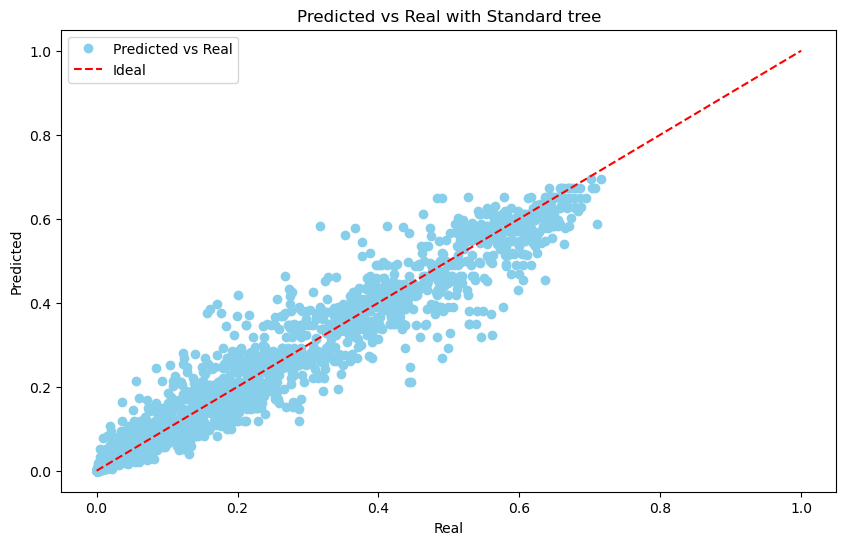

In [23]:
#plot results
plt.figure(figsize=(10, 6))
#dots in skyblue and edge in black
plt.plot(y_AdjTest, dfTS_eval['DT'], 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with Standard tree')
plt.legend()
plt.show()

Los resultados obtenidos mediante el Árbol de Regresión Estándar muestran un MSE de entrenamiento de 0.0009487122198021574 y un MSE de prueba de 0.0014700227619142377, junto con un MAE de entrenamiento de 0.015840277228307772 y un MAE de prueba de 0.019418578566483977. Estas métricas indican un alto grado de precisión en las predicciones del modelo, reflejando su capacidad para adaptarse bien a los datos de entrenamiento mientras mantiene una buena generalización a nuevos datos. Sin embargo, la ligera diferencia entre los errores de entrenamiento y prueba sugiere margen para mejorar la robustez del modelo frente a la variabilidad de los datos.

### 3.2 Bagged Tree

La técnica de Bagging, aplicada con Árboles de Regresión, introduce un método de ensamble que busca mejorar la estabilidad y precisión de los modelos predictivos en la estimación de la utilización solar. Al generar múltiples árboles a partir de subconjuntos de datos y luego combinar sus predicciones, el método busca reducir la varianza y evitar el sobreajuste, aprovechando así de manera más eficiente la información contenida en la irradiación solar.

In [27]:
num_estimators = 50
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeRegressor( criterion='squared_error',  # impurity measure
                                                            min_samples_split=23, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=10, # Minimum number of obs in a terminal node
                                                            random_state=0, # For replication
                                                            min_impurity_decrease=0))])

# Fit model
param = {'BT__n_estimators': range(20, 150, 5)} # Number of trees to aggregate

pipe =  Pipeline(steps=[('BT', 
                            BaggingRegressor(estimator=base_estimator,
                                              random_state=0))])

nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_absolute_error',  
                       cv=nFolds) # Number of Folds 

bt_fit.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingRegressor(estimator=Pipeline(steps=[('DT',
                                                                                    DecisionTreeRegressor(min_impurity_decrease=0,
                                                                                                          min_samples_leaf=10,
                                                                                                          min_samples_split=23,
                                                                                                          random_state=0))]),
                                                         random_state=0))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='neg_mean_absolute_error')

In [28]:
print(bt_fit.best_params_)

{'BT__n_estimators': 140}


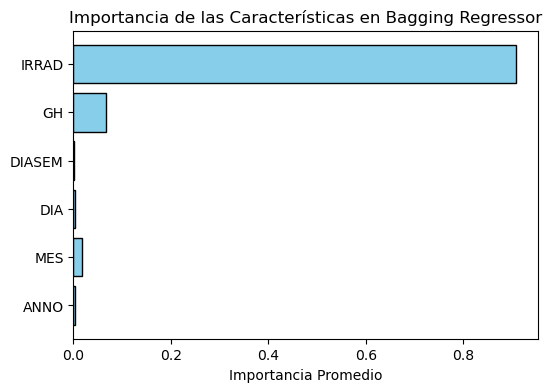

In [36]:
best_model = bt_fit.best_estimator_

bagging_regressor = best_model.named_steps['BT']

feature_importances_sum = np.zeros(len(X_train.columns))

for estimator in bagging_regressor.estimators_:
    feature_importances_sum += estimator.named_steps['DT'].feature_importances_

feature_importances_avg = feature_importances_sum / len(bagging_regressor.estimators_)

feature_names = X_train.columns.tolist()

y_pos = np.arange(len(feature_names))

plt.figure(figsize=(6, 4))
plt.barh(y_pos, feature_importances_avg, align='center', color='skyblue', edgecolor='black')
plt.yticks(y_pos, feature_names)
plt.xlabel('Importancia Promedio')
plt.title('Importancia de las Características en Bagging Regressor')

plt.show()

In [27]:
#predict
dfTR_eval['Bagg'] = bt_fit.predict(X_train)
dfTS_eval['Bagg']= bt_fit.predict(X_AdjTest)

# Evaluate
mse_train_error = mean_squared_error(y_train, dfTR_eval['Bagg'])
mse_test_error = mean_squared_error(y_AdjTest, dfTS_eval['Bagg'])

mae_train_error = mean_absolute_error(y_train, dfTR_eval['Bagg'])
mae_test_error = mean_absolute_error(y_AdjTest, dfTS_eval['Bagg'])

print(f'MSE (TR, Bagging) = {mse_train_error}')
print(f'MSE (TS, Bagging) = {mse_test_error}')
print(f'MAE (TR, Bagging) = {mae_train_error}')
print(f'MAE (TS, Bagging) = {mae_test_error}')

MSE (TR, Bagging) = 0.0007812039611749995
MSE (TS, Bagging) = 0.0011836504798690163
MAE (TR, Bagging) = 0.014561377503241126
MAE (TS, Bagging) = 0.017666006196485257


Los resultados alcanzados con el modelo de Bagging con Árboles de Regresión evidencian una mejora notable en la precisión, con un MSE de entrenamiento de 0.0007812039611749995 y un MSE de prueba de 0.0011836504798690163, así como un MAE de entrenamiento de 0.014561377503241126 y un MAE de prueba de 0.017666006196485257. Estas métricas subrayan la eficacia del Bagging para consolidar la precisión de las predicciones, minimizando errores y ofreciendo un modelo más resiliente a la variabilidad de los datos. La reducción en la discrepancia entre los errores de entrenamiento y prueba también refleja una mejor generalización del modelo.

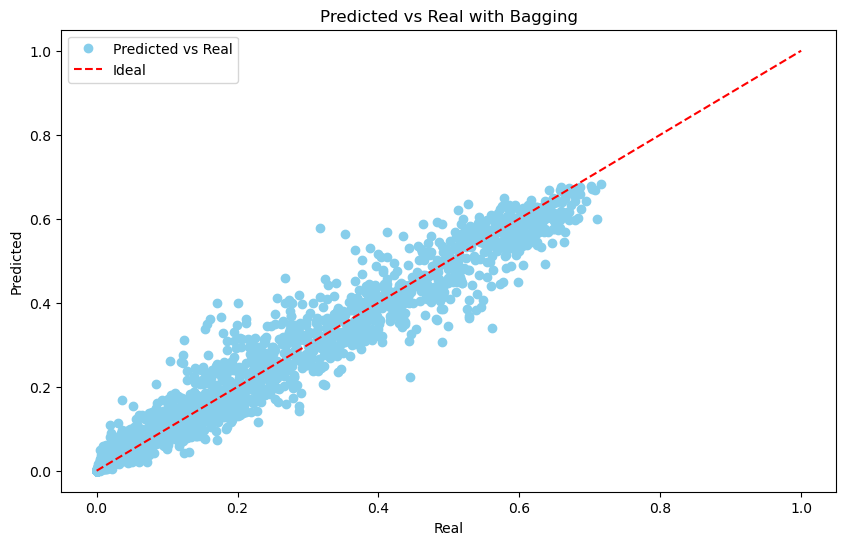

In [36]:
#plot results
plt.figure(figsize=(10, 6))
#dots in skyblue and edge in black
plt.plot(y_AdjTest, dfTS_eval['Bagg'], 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with Bagging')
plt.legend()
plt.show()

### 3.3 Random forest

El modelo de Random Forest lleva la idea del ensamble de árboles de decisión a un nivel superior, integrando la selección aleatoria de características en cada división para aumentar la diversidad entre los árboles. Esta estrategia no solo aborda el sobreajuste, sino que también mejora la capacidad del modelo para capturar la complejidad de la relación entre la irradiación solar y la utilización de energía solar, haciendo énfasis en la robustez y la precisión de las predicciones.

In [32]:
#random forest
from sklearn.ensemble import RandomForestRegressor

In [33]:
# Fit model
param = {'RF__n_estimators': range(20, 200, 5)} #Metiéndole esto tarda casi 10 mins

pipe =  Pipeline(steps=[('RF', 
                            RandomForestRegressor(criterion='squared_error', # impurity measure
                                                  min_samples_split=23, # Minimum number of obs in node to keep cutting
                                                  min_samples_leaf=10, # Minimum number of obs in a terminal node
                                                  random_state=0, # For replication
                                                  min_impurity_decrease=0))])

nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_absolute_error', 
                       cv=nFolds) # Number of Folds

rf_fit.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestRegressor(min_impurity_decrease=0,
                                                              min_samples_leaf=10,
                                                              min_samples_split=23,
                                                              random_state=0))]),
             n_jobs=-1, param_grid={'RF__n_estimators': range(20, 200, 5)},
             scoring='neg_mean_absolute_error')

In [45]:
#show best number of trees
print(rf_fit.best_params_)

{'RF__n_estimators': 140}


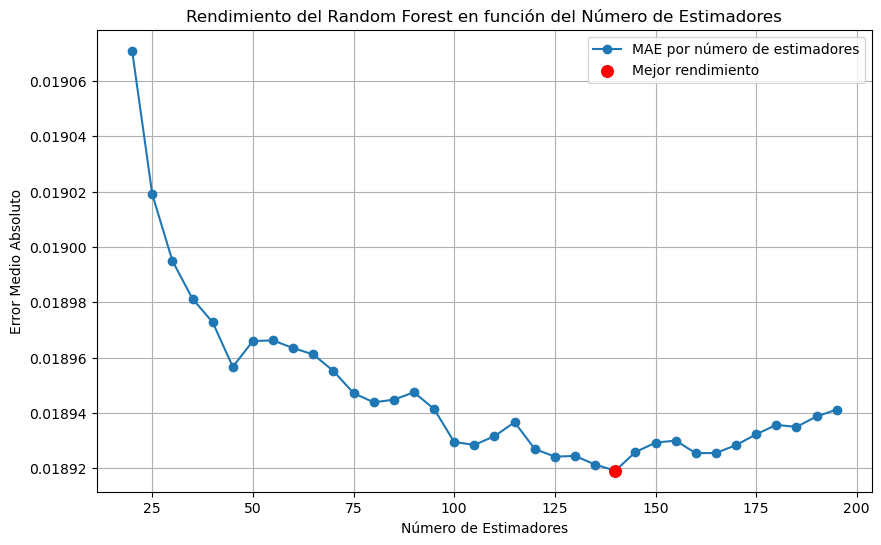

In [46]:
mean_scores = rf_fit.cv_results_['mean_test_score']

# Obtener los valores de n_estimators usados en el grid search
n_estimators_range = rf_fit.cv_results_['param_RF__n_estimators'].data

# Convertir el error medio absoluto negativo a positivo para facilitar la interpretación
mean_scores = -mean_scores

# Identificar el número de estimadores con el mejor rendimiento (menor error)
min_error = min(mean_scores)
best_n_estimators = n_estimators_range[mean_scores.argmin()]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, mean_scores, marker='o', label='MAE por número de estimadores')
plt.scatter(best_n_estimators, min_error, color='red', s=70, label='Mejor rendimiento', zorder=5)
plt.xlabel('Número de Estimadores')
plt.ylabel('Error Medio Absoluto')
plt.title('Rendimiento del Random Forest en función del Número de Estimadores')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

[0 1 2 3 4 5]
['ANNO', 'MES', 'DIA', 'DIASEM', 'GH', 'IRRAD']


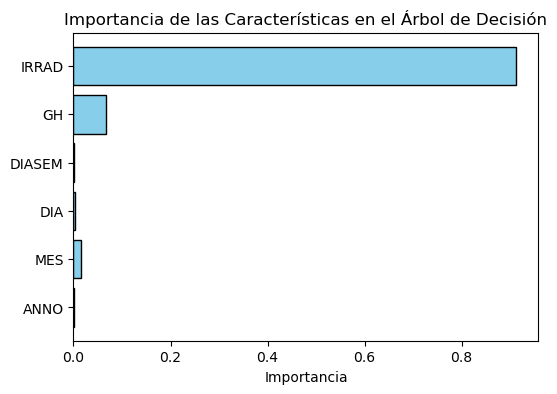

In [34]:
feature_importances = rf_fit.best_estimator_['RF'].feature_importances_

# Nombres de las características, asegurándose de convertirlas a lista si aún no lo son
feature_names = INPUTS.tolist()

# Crear las barras del gráfico
y_pos = np.arange(len(feature_names))

print(y_pos)
print(feature_names)

# Crear el gráfico de barras
plt.figure(figsize=(6, 4))
plt.barh(y_pos, feature_importances, align='center', color="skyblue", edgecolor='black')
plt.yticks(y_pos, feature_names)
plt.xlabel('Importancia')
plt.title('Importancia de las Características en el Random Forest')

# Mostrar el gráfico
plt.show()

In [47]:
#predict
dfTR_eval['RF'] = rf_fit.predict(X_train)
dfTS_eval['RF'] = rf_fit.predict(X_AdjTest)

# Evaluate
mse_train_error = mean_squared_error(y_train, dfTR_eval['RF'])
mse_test_error = mean_squared_error(y_AdjTest, dfTS_eval['RF'])

mae_train_error = mean_absolute_error(y_train, dfTR_eval['RF'])
mae_test_error = mean_absolute_error(y_AdjTest, dfTS_eval['RF'])

print(f'MSE (TR, Random Forest) = {mse_train_error}')
print(f'MSE (TS, Random Forest) = {mse_test_error}')
print(f'MAE (TR, Random Forest) = {mae_train_error}')
print(f'MAE (TS, Random Forest) = {mae_test_error}')

MSE (TR, Random Forest) = 0.000937671163879788
MSE (TS, Random Forest) = 0.0012178149438939697
MAE (TR, Random Forest) = 0.016104387259540907
MAE (TS, Random Forest) = 0.018018459119199404


La implementación de Random Forest en la predicción de la utilización solar presenta un MSE de entrenamiento de 0.000937671163879788 y un MSE de prueba de 0.0012178149438939697, con un MAE de entrenamiento de 0.016104387259540907 y un MAE de prueba de 0.018018459119199404. Estos resultados demuestran la eficiencia de Random Forest en la reducción de la varianza sin incrementar el sesgo, equilibrando adecuadamente entre el ajuste y la generalización. La ligera mejora en los errores de prueba en comparación con el modelo estándar y el Bagging indica que Random Forest es particularmente efectivo en la gestión de la diversidad de datos y en la mejora de la precisión de las predicciones.

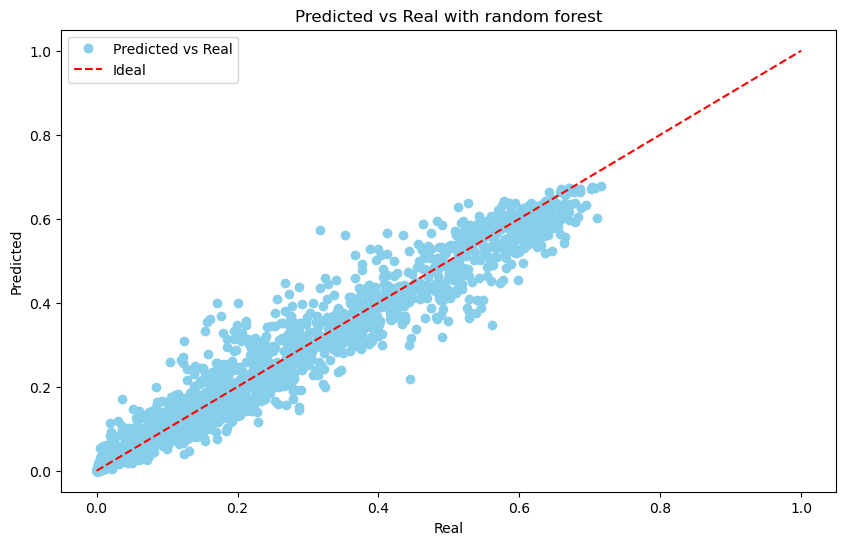

In [35]:
#plot results
plt.figure(figsize=(10, 6))
plt.plot(y_AdjTest, dfTS_eval['RF'], 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with random forest')
plt.legend()
plt.show()

### 3.4 Boosting 

In [115]:
 #TARDA 35 MINS

# Define the range of parameters for grid search
param_grid = {
    'base_estimator__max_depth': [10],  # max_depth for base estimator
    'n_estimators': np.arange(100, 5000, 500),   
    'learning_rate': np.arange(0.01,0.2, 0.01)
}

# Create AdaBoost Regressor with DecisionTreeRegressor as base estimator
AdaBoost_reg_tree = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(), random_state=0)

# Perform grid search
adaboost_fit = GridSearchCV(estimator=AdaBoost_reg_tree, param_grid=param_grid, cv=5)
adaboost_fit.fit(X_train, y_train)

# Get the best model
best_model = adaboost_fit.best_estimator_

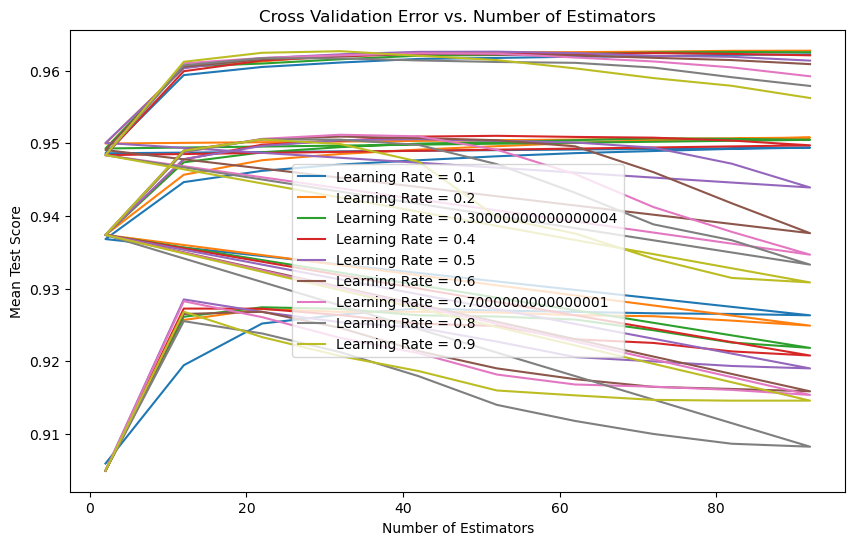

In [109]:
# Get mean test scores and corresponding parameters
results = adaboost_fit.cv_results_
n_estimators = results['param_n_estimators']
learning_rate = results['param_learning_rate']
mean_test_score = results['mean_test_score']

# Plot
plt.figure(figsize=(10, 6))
for lr in np.unique(learning_rate):
    lr_mask = (learning_rate == lr)
    plt.plot(n_estimators[lr_mask], mean_test_score[lr_mask], label=f'Learning Rate = {lr}')

plt.title('Cross Validation Error vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.legend()
plt.show()

Pruebas:

En un inicio, se realiza una búsqueda de los parámetros óptimos de nº estimadores y learning rate, y se obtiene que no hay mejora para cantidades de estimadores mayores a 100, pero lo que ocurre es que no se prueban valores del learning rate inferiores a 0.1.
Con esta búsqueda se fijó max_depth=3 y se obtenían errores del doble que para modelos anteriores.

Luego se incluye el max depth en la búsqueda, y para max depth=10, 10 estimadores y learning rate 0.2 se obtienen modelos similares o incluso algo mejores que para los modelos anteriores.

Ahora se está probando a incluir valores inferiores a 0.1 en la búsqueda y un mayor nº de estimadores.


In [113]:
print(adaboost_fit.best_params_)

{'base_estimator__max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 92}


In [114]:
#predict
dfTR_eval['Ada'] = adaboost_fit.predict(X_train)
dfTS_eval['Ada'] = adaboost_fit.predict(X_AdjTest)

# Evaluate
mse_train_error = mean_squared_error(y_train, dfTR_eval['Ada'])
mse_test_error = mean_squared_error(y_AdjTest, dfTS_eval['Ada'])

mae_train_error = mean_absolute_error(y_train, dfTR_eval['Ada'])
mae_test_error = mean_absolute_error(y_AdjTest, dfTS_eval['Ada'])

print(f'MSE (TR, AdaBoost) = {mse_train_error}')
print(f'MSE (TS, AdaBoost) = {mse_test_error}')
print(f'MAE (TR, AdaBoost) = {mae_train_error}')
print(f'MAE (TS, AdaBoost) = {mae_test_error}')

Train error: 0.010770860807033447
Test error: 0.017693051407053243


In [ ]:
#plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, dfTS_eval['Ada'], 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with random forest')
plt.legend()
plt.show()

#### Gradient Boosting

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 500, 1000],  # number of estimators
    'learning_rate': [0.01, 0.1, 1.0],  # learning rate
    'max_depth': [1, 3, 5],
    'min_impurity_decrease':[0,1e-5,1e-3,1e-2]  # max depth of base estimator
}

 
min_impurity_decrease = 0.001 * np.var(y_train)

# Create GradientBoostingRegressor
GB_reg_estim = GradientBoostingRegressor(
    loss='squared_error',# Minimum number of obs in a terminal node
    random_state=0
)

# Perform grid search
gb_fit = GridSearchCV(estimator=GB_reg_estim, param_grid=param_grid, cv=5)
gb_fit.fit(X.reshape(-1, 1), y)

# Get the best model
best_model = gb_fit.best_estimator_

# See the best parameters
print("Best parameters:", gb_fit.best_params_)

In [ ]:
#predict
dfTR_eval['Gb'] = gb_fit.predict(X_train)
dfTS_eval['Gb'] = gb_fit.predict(X_AdjTest)

# Evaluate
mse_train_error = mean_squared_error(y_train, dfTR_eval['Gb'])
mse_test_error = mean_squared_error(y_AdjTest, dfTS_eval['Gb'])

mae_train_error = mean_absolute_error(y_train, dfTR_eval['Gb'])
mae_test_error = mean_absolute_error(y_AdjTest, dfTS_eval['Gb'])

print(f'MSE (TR, Gradient Boosting) = {mse_train_error}')
print(f'MSE (TS, Gradient Boosting) = {mse_test_error}')
print(f'MAE (TR, Gradient Boosting) = {mae_train_error}')
print(f'MAE (TS, AdaBGradient Boostingoost) = {mae_test_error}')

In [ ]:
#plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, dfTS_eval['Gb'], 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with random forest')
plt.legend()
plt.show()

In [ ]:
importances_bag_class_estim = permutation_importance(gb_fit, 
                                    X_train[INPUTS], y_train,
                                    n_repeats=10,
                                    random_state=0)

fig = plt.figure(2, figsize=(8, 4)) 
plt.bar(INPUTS, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

#### 4.5 Stacking

El modelo de stacking implica combinar las predicciones de múltiples modelos base para generar una predicción final. En este enfoque, se pueden utilizar diversas técnicas de aprendizaje automático para construir los modelos base. En el primer caso, se combina un árbol de decisión simple, viato anteriorment, con un modelo polinómico para mejorar la capacidad predictiva inicial.

In [66]:
degree_poly = 15

# grid in min_impurity x min_samples_leaf x min_samples_split
param_tree = {'DT__min_impurity_decrease': np.arange(0, 0.1 ,0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': [10], # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(2,30,1)} 

pipe_tree = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                     random_state=0))]) # For replication

nFolds_tree = 10

## set of estimators to be stacked
estimators = [
    ('singregtree', make_pipeline(
                GridSearchCV(estimator= pipe_tree,
                            param_grid=param_tree, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='neg_mean_absolute_error',
                            cv=nFolds_tree)) # Number of Folds
    ),
    ('poly', make_pipeline(
        PolynomialFeatures(degree_poly), 
        Ridge(alpha=1e-3))
    )
]

estimators

[('poly',
  Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=15)),
                  ('ridge', Ridge(alpha=0.001))])),
 ('spline',
  Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=25)),
                  ('ridge', Ridge(alpha=0.001))])),
 ('regtree',
  Pipeline(steps=[('gridsearchcv',
                   GridSearchCV(cv=10,
                                estimator=Pipeline(steps=[('DT',
                                                           DecisionTreeRegressor(random_state=150))]),
                                n_jobs=-1,
                                param_grid={'DT__min_impurity_decrease': array([0.]),
                                            'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                            'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}))]))]

In [70]:
weights = [0.6, 0.4]
stacked_reg = VotingRegressor(estimators = estimators, weights = weights)
stacked_reg = stacked_reg.fit(X_train, y_train)
stacked_reg.get_params()

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/Caskroom/minifo

{'estimators': [('poly',
   Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=15)),
                   ('ridge', Ridge(alpha=0.001))])),
  ('spline',
   Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=25)),
                   ('ridge', Ridge(alpha=0.001))])),
  ('regtree',
   Pipeline(steps=[('gridsearchcv',
                    GridSearchCV(cv=10,
                                 estimator=Pipeline(steps=[('DT',
                                                            DecisionTreeRegressor(random_state=150))]),
                                 n_jobs=-1,
                                 param_grid={'DT__min_impurity_decrease': array([0.]),
                                             'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                             'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}))]))],
 'n_jobs': None,
 'verbose': False,
 'weights': [0.1, 0.2, 0.7],
 'poly': Pipeline(steps=[('polynomi

In [73]:
# estimations using the stacked models
y_train_stack = stacked_reg.predict(X_train)
y_test_stack = stacked_reg.predict(X_test)

# errors
mse_tr_stack = mean_squared_error(y_train_stack, y_train)
mse_ts_stack = mean_squared_error(y_test_stack, y_test)

mae_tr_stack = mean_absolute_error(y_train_stack, y_train)
mae_ts_stack = mean_absolute_error(y_test_stack, y_test)

print(f'MSE(TR, stack) = {mse_tr_stack}')
print(f'MSE(TS, stack) = {mse_ts_stack}')
print(f'MAE(TR, stack) = {mae_tr_stack}')
print(f'MAE(TS, stack) = {mae_ts_stack}')

MSE(TR, stack) = 0.0012298384943441247
MSE(TS, stack) = 0.0017803233807022357
MAE(TR, stack) = 0.023792830360222554
MAE(TS, stack) = 0.027339933455514095


In [ ]:
Train error: 0.016267130859527804
Test error: 0.01931007901778223

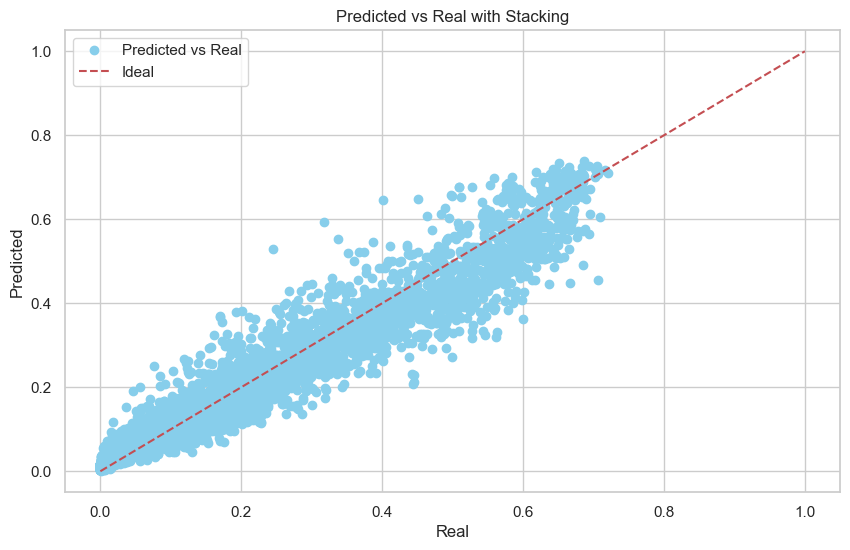

In [81]:
#plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_test_stack, 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with Stacking')
plt.legend()
plt.show()

Una vez que hemos mejorado el modelo más sencillo seleccionamos el mejor modelo entrenado, en este caso, el modelo de boosting, procedemos a combinarlo con un MLP, que es un modelo distinto. Esta combinación se realiza con el fin de evitar la correlación entre ellos y potenciar así la capacidad predictiva del conjunto.

In [82]:
# Parámetros óptimos para la red neuronal
param_nn_opt = {
    'hidden_layer_sizes': [(3,), (5,), (5,1), (5,3)],
    'activation': ['logistic'],
    'alpha': [1e-3, 5, 8]
}

# Define the range of parameters for grid search
param_boost_opt = {
    'base_estimator__max_depth': [10],
    'n_estimators': [92],
    'learning_rate': [0.1]
}

# Create AdaBoost Regressor with DecisionTreeRegressor as base estimator
AdaBoost_reg_tree_opt = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(), 
    random_state=0
)

# Define the grid search for neural network
grid_nn = GridSearchCV(
    estimator=MLPRegressor(max_iter=1000, random_state=0),
    param_grid=param_nn_opt,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    cv=10
)

# Lista de estimadores para el stacking
estimators = [
    ('boost', AdaBoost_reg_tree_opt),
    ('nn', grid_nn)
]

estimators

[('boost',
  AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=0)),
 ('nn',
  GridSearchCV(cv=10, estimator=MLPRegressor(max_iter=1000, random_state=0),
               n_jobs=-1,
               param_grid={'activation': ['logistic'], 'alpha': [0.001, 5, 8],
                           'hidden_layer_sizes': [(3,), (5,), (5, 1), (5, 3)]},
               scoring='neg_mean_absolute_error'))]

In [83]:
weights = [0.6, 0.4]
stacked_reg = VotingRegressor(estimators = estimators, weights = weights)
stacked_reg = stacked_reg.fit(X_train, y_train)
stacked_reg.get_params()

{'estimators': [('boost',
   AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=0)),
  ('nn',
   GridSearchCV(cv=10, estimator=MLPRegressor(max_iter=1000, random_state=0),
                n_jobs=-1,
                param_grid={'activation': ['logistic'], 'alpha': [0.001, 5, 8],
                            'hidden_layer_sizes': [(3,), (5,), (5, 1), (5, 3)]},
                scoring='neg_mean_absolute_error'))],
 'n_jobs': None,
 'verbose': False,
 'weights': [0.6, 0.4],
 'boost': AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=0),
 'nn': GridSearchCV(cv=10, estimator=MLPRegressor(max_iter=1000, random_state=0),
              n_jobs=-1,
              param_grid={'activation': ['logistic'], 'alpha': [0.001, 5, 8],
                          'hidden_layer_sizes': [(3,), (5,), (5, 1), (5, 3)]},
              scoring='neg_mean_absolute_error'),
 'boost__base_estimator__ccp_alpha': 0.0,
 'boost__base_estimator__criterion': 'squared_error',
 'boost__ba

In [71]:
# estimations using the stacked models
y_train_stack = stacked_reg.predict(X_train)
y_test_stack = stacked_reg.predict(X_test)

# errors
mse_tr_stack = mean_squared_error(y_train_stack, y_train)
mse_ts_stack = mean_squared_error(y_test_stack, y_test)

mae_tr_stack = mean_absolute_error(y_train_stack, y_train)
mae_ts_stack = mean_absolute_error(y_test_stack, y_test)

print(f'MSE(TR, stack) = {mse_tr_stack}')
print(f'MSE(TS, stack) = {mse_ts_stack}')
print(f'MAE(TR, stack) = {mae_tr_stack}')
print(f'MAE(TS, stack) = {mae_ts_stack}')

MSE(TR, stack) = 0.0030644660611498353
MSE(TS, stack) = 0.004031143104694253
MAE(TR, stack) = 0.03512629862991086
MAE(TS, stack) = 0.03949460221298314


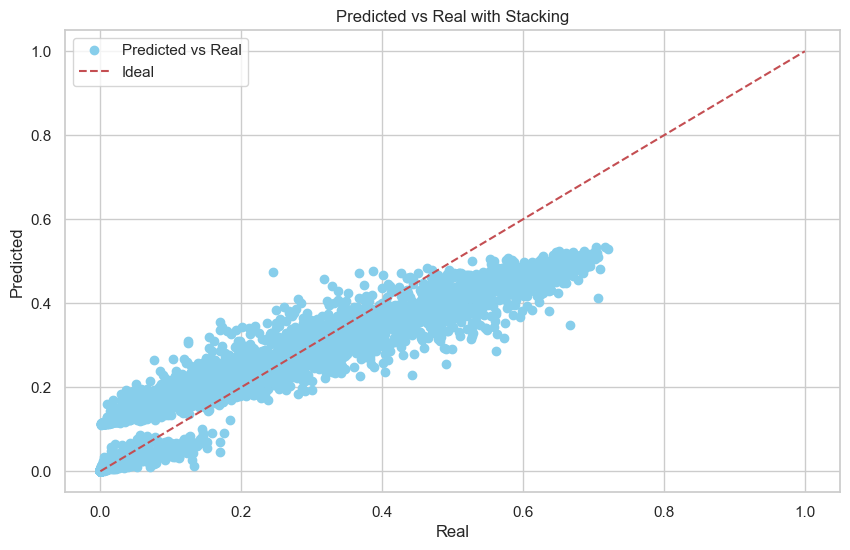

In [72]:
#plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_test_stack, 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with Stacking')
plt.legend()
plt.show()

In [104]:
# Obtener las predicciones del modelo de stacking para el conjunto de entrenamiento original
stacked_train_predictions = stacked_reg.predict(X_train)

# Concatenar las predicciones del modelo de stacking con el conjunto de entrenamiento original
X_train_stacked = np.concatenate((X_train, stacked_train_predictions.reshape(-1, 1)), axis=1)

# Definir los parámetros para el nuevo modelo MLP
param_new_mlp = {
    'hidden_layer_sizes': [(10,), (20,), (30,)],
    'activation': ['logistic'],
    'alpha': [1e-3, 1e-4],
    'max_iter': [1000]
}

# Realizar la búsqueda en la grilla para el nuevo modelo MLP
grid_new_mlp = GridSearchCV(
    estimator=MLPRegressor(random_state=0),
    param_grid=param_new_mlp,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    cv=10
)

# Entrenar el nuevo modelo MLP
grid_new_mlp.fit(X_train_stacked, y_train)

print("Trained model")

Trained model


In [105]:
# estimations using the stacked models
y_train_stack = grid_new_mlp.predict(X_train_stacked)
y_test_stack = grid_new_mlp.predict(X_test_stacked)

# errors
mse_tr_stack = mean_squared_error(y_train_stack, y_train)
mse_ts_stack = mean_squared_error(y_test_stack, y_test)

mae_tr_stack = mean_absolute_error(y_train_stack, y_train)
mae_ts_stack = mean_absolute_error(y_test_stack, y_test)

print(f'MSE(TR, stack) = {mse_tr_stack}')
print(f'MSE(TS, stack) = {mse_ts_stack}')
print(f'MAE(TR, stack) = {mae_tr_stack}')
print(f'MAE(TS, stack) = {mae_ts_stack}')

MSE(TR, stack) = 0.0191418569402712
MSE(TS, stack) = 0.019162071940467026
MAE(TR, stack) = 0.08681930521387703
MAE(TS, stack) = 0.0862153994390728


# estimations using the stacked models
y_train_stack = stacked_reg.predict(X_train)
y_test_stack = stacked_reg.predict(X_test)

# errors
mse_tr_stack = mean_squared_error(y_train_stack, y_train)
mse_ts_stack = mean_squared_error(y_test_stack, y_test)

mae_tr_stack = mean_absolute_error(y_train_stack, y_train)
mae_ts_stack = mean_absolute_error(y_test_stack, y_test)

print(f'MSE(TR, stack) = {mse_tr_stack}')
print(f'MSE(TS, stack) = {mse_ts_stack}')
print(f'MAE(TR, stack) = {mae_tr_stack}')
print(f'MAE(TS, stack) = {mae_ts_stack}')

#plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_test_stack, 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real with Stacking')
plt.legend()
plt.show()